1.
do they do measure performance by campaign period,
performance by product, closed and won

2.
total sales * probability_prc = weighted sales

weighted sales  opportunities with higher likelihoods of closing are given more weight in sales forecasting

ml model for weighted sales

assuming acquisition costs are the same

3. Most success
Clients with CLOSED opportunities. Check general statistics for that.
Are they getting more closed opportunities with new clients? In certain regions? Sectors? Industries? customer_program_desc? campaign runtime over a certain amount of days? under?

# 1. Library Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

pd.set_option('display.max_columns', None)

# 2. Data Imports and Initial Exploration

-Importing each CSV into a separate DataFrame
<br>-Reviewing general data information and DataFrame column dtype

In [2]:
base_customer = pd.read_csv('Case_Study_Data/BaseCustomer.csv')
customer_opportunity = pd.read_csv('Case_Study_Data/CustomerOpportunity.csv')
product_mapping = pd.read_csv('Case_Study_Data/ProductMapping.csv')

### 2.1 base_customer DataFrame

This DataFrame comprises of 96521 entries, 13 columns.

Consists of a unique customer ID and columns for descriptors like which industry, if they're a new client, office description, region, sector, subsector.

A customer with a specific ID **can be in this chart multiple times** for different snapshot fiscal year periods.

In [3]:
base_customer.head()

,SNAPSHOT_FISCAL_YEAR,SNAPSHOT_FISCAL_YEAR_PERIOD,customer,customer_PROGRAM_DESC,customer_TEXT,New_Client_Flag,customer_INDUSTRY_DESC,customer_salelead,customer_OFFICE_DESC,customer_REGION_DESC,customer_SECTOR_DESC,customer_SIC_TEXT,customer_SUB_SECTOR_DESC
0,2019,2019013,24065391.0,NaN,customer563,NaN,Industry1,NaN,NON-US,US - National Office,Sector22,SIC62,Sub Sector53
1,2019,2019009,24057411.0,NaN,customer2118,NaN,INDUSTRY7,NaN,PHOENIX,US - West,Sector21,SIC983,Sub Sector57
2,2020,2020004,24069264.0,NaN,customer9021,NaN,Industry1,NaN,BOSTON,US - East,Sector4,SIC618,Sub Sector44
3,2020,2020006,24476988.0,NaN,customer6698,NaN,INDUSTRY7,NaN,NON-US,US - National Office,Sector20,SIC808,Sub Sector54
4,2020,2020006,24032544.0,NaN,customer1587,NaN,INDUSTRY3,NaN,BOSTON,US - East,Sector2,SIC905,Sub Sector7


In [4]:
base_customer.columns

Index(['SNAPSHOT_FISCAL_YEAR', 'SNAPSHOT_FISCAL_YEAR_PERIOD', 'customer',
       'customer_PROGRAM_DESC', 'customer_TEXT', 'New_Client_Flag',
       'customer_INDUSTRY_DESC', 'customer_salelead', 'customer_OFFICE_DESC',
       'customer_REGION_DESC', 'customer_SECTOR_DESC', 'customer_SIC_TEXT',
       'customer_SUB_SECTOR_DESC'],
      dtype='object')

In [5]:
base_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96521 entries, 0 to 96520
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SNAPSHOT_FISCAL_YEAR         96521 non-null  int64  
 1   SNAPSHOT_FISCAL_YEAR_PERIOD  96521 non-null  int64  
 2   customer                     96507 non-null  float64
 3   customer_PROGRAM_DESC        12863 non-null  object 
 4   customer_TEXT                96507 non-null  object 
 5   New_Client_Flag              4012 non-null   object 
 6   customer_INDUSTRY_DESC       96507 non-null  object 
 7   customer_salelead            20153 non-null  object 
 8   customer_OFFICE_DESC         96500 non-null  object 
 9   customer_REGION_DESC         96500 non-null  object 
 10  customer_SECTOR_DESC         96507 non-null  object 
 11  customer_SIC_TEXT            96507 non-null  object 
 12  customer_SUB_SECTOR_DESC     96507 non-null  object 
dtypes: float64(1), i

### 2.2 customer_opportunity DataFrame

The customer_opportunity DataFrame consists of 550857 entries and 23 columns.

This contains the sale data for a customer id, total sales, weighted sales, snapshot fiscal year period, and the start and end date for projects.

This data contains a product category 4 id that will relate to the next chart that identifies a separate product category.

In [6]:
customer_opportunity.head()

,OPPORTUNITY_OPEN_CLOSED_INDICATOR,PHASE_NAME,PURSUIT_START_DATE,PROJECT_START_DATE,PROJECT_END_DATE,PERIOD_WON_LOSS_ABANDONED,DATE_WON_LOSS_ABANDONED,PRIORITY,customer,Product_Category4_id,Product_Category2_text,Product_Category3_text,PURSUIT_LEADER,BUYER_ROLE_DESC,CURRENCY,PROBABILITY_PRC,WEIGHTED_Sales,Total_Sales,STRATEGIC_OPPORTUNITY,SNAPSHOT_FY,SNAPSHOT_FP,SNAPSHOT_FISCAL_YEAR_PERIOD,OPPORTUNITY_ID
0,CLOSED,Abandoned,3/13/2018,10/1/2019,4/2/2020,Period 04 2020,8/30/2019,NaN,24031560.0,1878.0,category68,sub category91,22241.0,NaN,USD,0,0.0,550000,NaN,2020,4,2020004,MO-28949
1,OPEN,phase 5,3/13/2018,6/3/2019,12/2/2019,NaN,NaN,NaN,24031560.0,1878.0,category68,sub category91,22241.0,NaN,USD,25,137500.0,550000,NaN,2019,11,2019011,MO-28949
2,OPEN,phase 5,3/13/2018,10/1/2019,4/2/2020,NaN,NaN,NaN,24031560.0,1878.0,category68,sub category91,22241.0,NaN,USD,25,137500.0,550000,NaN,2020,3,2020003,MO-28949
3,OPEN,phase 5,3/13/2018,6/3/2019,12/2/2019,NaN,NaN,NaN,24031560.0,1878.0,category68,sub category91,22241.0,NaN,USD,25,137500.0,550000,NaN,2019,12,2019012,MO-28949
4,OPEN,phase 5,3/13/2018,3/4/2019,10/1/2019,NaN,NaN,NaN,24031560.0,1878.0,category68,sub category91,22241.0,NaN,USD,25,137500.0,550000,NaN,2019,9,2019009,MO-28949


In [7]:
customer_opportunity.columns

Index(['OPPORTUNITY_OPEN_CLOSED_INDICATOR', 'PHASE_NAME', 'PURSUIT_START_DATE',
       'PROJECT_START_DATE', 'PROJECT_END_DATE', 'PERIOD_WON_LOSS_ABANDONED',
       'DATE_WON_LOSS_ABANDONED', 'PRIORITY', 'customer',
       'Product_Category4_id', 'Product_Category2_text',
       'Product_Category3_text', 'PURSUIT_LEADER', 'BUYER_ROLE_DESC',
       'CURRENCY', 'PROBABILITY_PRC', 'WEIGHTED_Sales', 'Total_Sales',
       'STRATEGIC_OPPORTUNITY', 'SNAPSHOT_FY', 'SNAPSHOT_FP',
       'SNAPSHOT_FISCAL_YEAR_PERIOD', 'OPPORTUNITY_ID'],
      dtype='object')

In [8]:
customer_opportunity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550857 entries, 0 to 550856
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   OPPORTUNITY_OPEN_CLOSED_INDICATOR  550857 non-null  object 
 1   PHASE_NAME                         550857 non-null  object 
 2   PURSUIT_START_DATE                 550857 non-null  object 
 3   PROJECT_START_DATE                 313496 non-null  object 
 4   PROJECT_END_DATE                   301941 non-null  object 
 5   PERIOD_WON_LOSS_ABANDONED          74452 non-null   object 
 6   DATE_WON_LOSS_ABANDONED            74452 non-null   object 
 7   PRIORITY                           18882 non-null   object 
 8   customer                           519395 non-null  float64
 9   Product_Category4_id               518548 non-null  float64
 10  Product_Category2_text             542149 non-null  object 
 11  Product_Category3_text             5295

### 2.3 product_mapping DataFrame

This DataFrame consists of 639 entries and 12 columns.

There is an entry of 1 to specify what category the product category 4 id fits in.

There are excess columns due to data entry errors.

In [9]:
product_mapping.head()

,Product_Category4_id,Category1,CATEGORY1,Category2,CategorY3,Category4,CAtegory3,Category3,CaTegory1,CategOry2,CATEgory3,category3
0,126,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1,129,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2,132,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,135,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
4,138,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [10]:
product_mapping.columns

Index(['Product_Category4_id', 'Category1', 'CATEGORY1', 'Category2',
       'CategorY3', 'Category4', 'CAtegory3', 'Category3', 'CaTegory1',
       'CategOry2', 'CATEgory3', 'category3'],
      dtype='object')

In [11]:
product_mapping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639 entries, 0 to 638
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Product_Category4_id  639 non-null    int64  
 1   Category1             26 non-null     float64
 2   CATEGORY1             171 non-null    float64
 3   Category2             109 non-null    float64
 4   CategorY3             30 non-null     float64
 5   Category4             2 non-null      float64
 6   CAtegory3             3 non-null      float64
 7   Category3             258 non-null    float64
 8   CaTegory1             21 non-null     float64
 9   CategOry2             3 non-null      float64
 10  CATEgory3             6 non-null      float64
 11  category3             10 non-null     float64
dtypes: float64(11), int64(1)
memory usage: 60.0 KB


In [12]:
product_mapping['Product_Category4_id'].value_counts()

1629     2
2859     2
2004     2
2001     2
750      1
        ..
4638     1
18168    1
24723    1
15186    1
15354    1
Name: Product_Category4_id, Length: 635, dtype: int64

In [13]:
customer_opportunity['OPPORTUNITY_ID'].value_counts()

MO-235591     605
MO-2430685    280
MO-2245937    245
MO-221129     195
MO-2430689    183
             ... 
MO-2872465      1
MO-2966863      1
MO-2728625      1
MO-2831939      1
MO-2891869      1
Name: OPPORTUNITY_ID, Length: 104997, dtype: int64

In [14]:
customer_opportunity[customer_opportunity['OPPORTUNITY_ID']=='MO-235591']['WEIGHTED_Sales'].value_counts()

0.0    605
Name: WEIGHTED_Sales, dtype: int64

In [15]:
base_customer['customer_PROGRAM_DESC'].value_counts()

program4    2432
program3    2030
program5    1984
program9    1770
program2    1594
program6    1409
program8     837
program1     807
Name: customer_PROGRAM_DESC, dtype: int64

In [16]:
customer_opportunity['Product_Category2_text'].value_counts()

category50    128493
category6      67326
category18     39042
category68     38330
category51     37022
               ...  
category15        12
category59         4
category41         3
category5          1
category1          1
Name: Product_Category2_text, Length: 64, dtype: int64

In [17]:
customer_opportunity['Product_Category3_text'].value_counts()

sub category180    157249
sub category80      44679
sub category124     22295
sub category8       19615
sub category152     16403
                    ...  
sub category86          1
sub category123         1
sub category156         1
sub category162         1
sub category13          1
Name: Product_Category3_text, Length: 168, dtype: int64

In [18]:
base_customer[base_customer['customer_PROGRAM_DESC']=='program1']

,SNAPSHOT_FISCAL_YEAR,SNAPSHOT_FISCAL_YEAR_PERIOD,customer,customer_PROGRAM_DESC,customer_TEXT,New_Client_Flag,customer_INDUSTRY_DESC,customer_salelead,customer_OFFICE_DESC,customer_REGION_DESC,customer_SECTOR_DESC,customer_SIC_TEXT,customer_SUB_SECTOR_DESC
289,2019,2019009,24001572.0,program1,customer6895,NaN,Industry3,sale lead420,NEW YORK,US - East,Sector2,SIC155,Sub Sector7
298,2019,2019008,24000144.0,program1,customer9737,NaN,INDUSTRY5,sale lead635,NEW YORK,US - East,Sector13,SIC774,Sub Sector8
640,2019,2019012,24019260.0,program1,customer3021,NaN,INDUSTRY5,sale lead988,DENVER,US - Central,Sector7,SIC394,Sub Sector22
767,2020,2020005,24001497.0,program1,customer2585,NaN,Industry2,sale lead726,SAN FRANCISCO (INCL. OAKLAND),US - West,Sector15,SIC773,Sub Sector42
882,2020,2020001,24016845.0,program1,customer5755,NaN,INDUSTRY5,sale lead629,CHICAGO,US - Central,Sector7,SIC85,Sub Sector23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95954,2019,2019013,24019260.0,program1,customer3021,NaN,INDUSTRY5,sale lead988,DENVER,US - Central,Sector7,SIC394,Sub Sector22
96175,2019,2019010,24007521.0,program1,customer3030,Y,Industry4,sale lead412,CAMP HILL,US - Central,Sector19,SIC955,Sub Sector56
96223,2019,2019013,24024003.0,program1,customer3609,Y,Industry4,sale lead1152,WASHINGTON DC,US - East,Sector5,SIC324,Sub Sector14
96268,2020,2020002,24006150.0,program1,customer6863,NaN,INDUSTRY5,sale lead1130,PARSIPPANY,US - East,Sector13,SIC972,Sub Sector36


# 3. Data Cleaning


**Cleaning the product_mapping data frame.** There are multiple columns that are different spellings of the same category.

Replacing all nulls with 0 then summing all similar categories. Once complete, we check the dataframe and then change the data types from floats to ints and drop duplicate entries.

In [19]:
product_mapping.head()

,Product_Category4_id,Category1,CATEGORY1,Category2,CategorY3,Category4,CAtegory3,Category3,CaTegory1,CategOry2,CATEgory3,category3
0,126,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
1,129,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2,132,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
3,135,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
4,138,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [20]:
product_mapping = product_mapping.fillna(0)

In [21]:
clean_product_mapping = pd.DataFrame()

In [22]:
clean_product_mapping['Product_Category4_id'] = product_mapping['Product_Category4_id']

In [23]:
clean_product_mapping['Category1'] = product_mapping['Category1']+product_mapping['CATEGORY1']+product_mapping['CaTegory1']
clean_product_mapping['Category2'] = product_mapping['Category2']+product_mapping['CategOry2']
clean_product_mapping['Category3'] = \
    product_mapping['CategorY3']+product_mapping['CAtegory3']+\
    product_mapping['Category3']+product_mapping['CATEgory3']+product_mapping['category3']
clean_product_mapping['Category4'] = product_mapping['Category4']

In [24]:
clean_product_mapping.head()

,Product_Category4_id,Category1,Category2,Category3,Category4
0,126,0.0,0.0,1.0,0.0
1,129,0.0,0.0,1.0,0.0
2,132,0.0,0.0,1.0,0.0
3,135,0.0,0.0,1.0,0.0
4,138,0.0,0.0,1.0,0.0


In [25]:
clean_product_mapping = clean_product_mapping.astype('int')

In [26]:
clean_product_mapping.head()

,Product_Category4_id,Category1,Category2,Category3,Category4
0,126,0,0,1,0
1,129,0,0,1,0
2,132,0,0,1,0
3,135,0,0,1,0
4,138,0,0,1,0


In [27]:
clean_product_mapping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639 entries, 0 to 638
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Product_Category4_id  639 non-null    int32
 1   Category1             639 non-null    int32
 2   Category2             639 non-null    int32
 3   Category3             639 non-null    int32
 4   Category4             639 non-null    int32
dtypes: int32(5)
memory usage: 12.6 KB


In [28]:
clean_product_mapping[clean_product_mapping['Category1']==1]

,Product_Category4_id,Category1,Category2,Category3,Category4
139,1320,1,0,0,0
141,1335,1,0,0,0
149,1626,1,0,0,0
150,1629,1,0,0,0
151,1629,1,0,0,0
...,...,...,...,...,...
631,24975,1,0,0,0
632,24978,1,0,0,0
633,24984,1,0,0,0
634,25029,1,0,0,0


In [29]:
clean_product_mapping.duplicated().sum()

4

In [30]:
clean_product_mapping = clean_product_mapping.drop_duplicates()

In [31]:
clean_product_mapping.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 635 entries, 0 to 638
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Product_Category4_id  635 non-null    int32
 1   Category1             635 non-null    int32
 2   Category2             635 non-null    int32
 3   Category3             635 non-null    int32
 4   Category4             635 non-null    int32
dtypes: int32(5)
memory usage: 17.4 KB


### Cleaning the base_customer DataFrame next



In [32]:
base_customer[base_customer['customer'].duplicated()]

,SNAPSHOT_FISCAL_YEAR,SNAPSHOT_FISCAL_YEAR_PERIOD,customer,customer_PROGRAM_DESC,customer_TEXT,New_Client_Flag,customer_INDUSTRY_DESC,customer_salelead,customer_OFFICE_DESC,customer_REGION_DESC,customer_SECTOR_DESC,customer_SIC_TEXT,customer_SUB_SECTOR_DESC
73,2019,2019013,24328485.0,NaN,customer9187,NaN,INDUSTRY5,NaN,NON-US,US - National Office,Sector13,SIC277,Sub Sector36
89,2020,2020007,24007620.0,NaN,customer13528,NaN,Industry2,NaN,GRAND RAPIDS (WEST MI),US - Central,Sector10,SIC309,Sub Sector31
196,2019,2019013,24010014.0,NaN,customer2645,NaN,INDUSTRY1,NaN,MINNEAPOLIS,US - Central,Sector18,SIC1067,Sub Sector55
243,2020,2020004,24460089.0,NaN,customer914,NaN,Industry6,NaN,NON-US,US - National Office,Sector23,SIC685,Sub Sector61
308,2019,2019010,24465780.0,NaN,customer1005,NaN,Industry4,NaN,WASHINGTON DC,US - East,Sector5,SIC324,Sub Sector14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96516,2020,2020001,24039162.0,NaN,customer5654,NaN,Industry3,NaN,TAMPA,US - East,Sector11,SIC531,Sub Sector33
96517,2019,2019008,24068100.0,NaN,customer3699,NaN,INDUSTRY3,NaN,NON-US,US - National Office,Sector2,SIC903,Sub Sector7
96518,2019,2019012,24042036.0,NaN,customer9139,NaN,INDUSTRY2,NaN,CHARLOTTE,US - East,Sector10,SIC21,Sub Sector31
96519,2020,2020007,24037269.0,NaN,customer6835,NaN,Industry3,NaN,DENVER,US - Central,Sector11,SIC491,Sub Sector9


In [33]:
base_customer[base_customer['customer']==24328485.0]

,SNAPSHOT_FISCAL_YEAR,SNAPSHOT_FISCAL_YEAR_PERIOD,customer,customer_PROGRAM_DESC,customer_TEXT,New_Client_Flag,customer_INDUSTRY_DESC,customer_salelead,customer_OFFICE_DESC,customer_REGION_DESC,customer_SECTOR_DESC,customer_SIC_TEXT,customer_SUB_SECTOR_DESC
13,2019,2019009,24328485.0,NaN,customer9187,NaN,Industry5,NaN,NON-US,US - National Office,Sector13,SIC277,Sub Sector36
73,2019,2019013,24328485.0,NaN,customer9187,NaN,INDUSTRY5,NaN,NON-US,US - National Office,Sector13,SIC277,Sub Sector36
669,2020,2020005,24328485.0,NaN,customer9187,NaN,Industry5,NaN,NON-US,US - National Office,Sector13,SIC277,Sub Sector36
16475,2020,2020001,24328485.0,NaN,customer9187,NaN,Industry5,NaN,NON-US,US - National Office,Sector13,SIC277,Sub Sector36
40566,2020,2020007,24328485.0,NaN,customer9187,NaN,Industry5,NaN,NON-US,US - National Office,Sector13,SIC277,Sub Sector36
44609,2020,2020003,24328485.0,NaN,customer9187,NaN,INDUSTRY5,NaN,NON-US,US - National Office,Sector13,SIC277,Sub Sector36
71810,2020,2020002,24328485.0,NaN,customer9187,NaN,Industry5,NaN,NON-US,US - National Office,Sector13,SIC277,Sub Sector36
77674,2019,2019007,24328485.0,NaN,customer9187,NaN,INDUSTRY5,NaN,NON-US,US - National Office,Sector13,SIC277,Sub Sector36
81952,2019,2019010,24328485.0,NaN,customer9187,NaN,Industry5,NaN,NON-US,US - National Office,Sector13,SIC277,Sub Sector36
86913,2020,2020006,24328485.0,NaN,customer9187,NaN,INDUSTRY5,NaN,NON-US,US - National Office,Sector13,SIC277,Sub Sector36


### Multiple entries per customer based on snapshop fiscal year period

In [34]:
base_customer['New_Client_Flag'].value_counts()

Y    4012
Name: New_Client_Flag, dtype: int64

In [35]:
base_customer['customer_INDUSTRY_DESC'].value_counts()

Industry1    11546
INDUSTRY1    11381
INDUSTRY3     9114
Industry3     8927
INDUSTRY2     7829
Industry2     7815
Industry7     6597
INDUSTRY7     6583
INDUSTRY5     5382
Industry5     5321
INDUSTRY6     4933
Industry6     4928
Industry4     3088
INDUSTRY4     3063
Name: customer_INDUSTRY_DESC, dtype: int64

- Cleaned the customer_INDUSTRY_DESC column to have uniform entries

In [36]:
base_customer.loc[base_customer['customer_INDUSTRY_DESC']=='INDUSTRY1', 'customer_INDUSTRY_DESC']= 'Industry1'
base_customer.loc[base_customer['customer_INDUSTRY_DESC']=='INDUSTRY2', 'customer_INDUSTRY_DESC']= 'Industry2'
base_customer.loc[base_customer['customer_INDUSTRY_DESC']=='INDUSTRY3', 'customer_INDUSTRY_DESC']= 'Industry3'
base_customer.loc[base_customer['customer_INDUSTRY_DESC']=='INDUSTRY4', 'customer_INDUSTRY_DESC']= 'Industry4'
base_customer.loc[base_customer['customer_INDUSTRY_DESC']=='INDUSTRY5', 'customer_INDUSTRY_DESC']= 'Industry5'
base_customer.loc[base_customer['customer_INDUSTRY_DESC']=='INDUSTRY6', 'customer_INDUSTRY_DESC']= 'Industry6'
base_customer.loc[base_customer['customer_INDUSTRY_DESC']=='INDUSTRY7', 'customer_INDUSTRY_DESC']= 'Industry7'

In [37]:
base_customer['customer_INDUSTRY_DESC'].value_counts()

Industry1    22927
Industry3    18041
Industry2    15644
Industry7    13180
Industry5    10703
Industry6     9861
Industry4     6151
Name: customer_INDUSTRY_DESC, dtype: int64

In [38]:
base_customer['customer_PROGRAM_DESC'].value_counts()

program4    2432
program3    2030
program5    1984
program9    1770
program2    1594
program6    1409
program8     837
program1     807
Name: customer_PROGRAM_DESC, dtype: int64

In [39]:
base_customer['customer_OFFICE_DESC'].value_counts().index

Index(['NEW YORK', 'NON-US', 'CHICAGO', 'LOS ANGELES', 'BOSTON',
       'SAN FRANCISCO (INCL. OAKLAND)', 'SAN JOSE', 'WASHINGTON DC', 'HOUSTON',
       'PARSIPPANY', 'PHILADELPHIA', 'ATLANTA', 'DALLAS', 'STAMFORD',
       'DETROIT (SE MI)', 'MINNEAPOLIS', 'DENVER', 'ORANGE COUNTY',
       'MILWAUKEE', 'SEATTLE', 'SAN DIEGO', 'PHOENIX', 'CINCINNATI',
       'CHARLOTTE', 'COLUMBUS', 'NASHVILLE', 'CLEVELAND (NE OHIO)',
       'SALT LAKE CITY', 'TAMPA', 'PITTSBURGH', 'INDIANAPOLIS', 'ST. LOUIS',
       'RALEIGH', 'KANSAS CITY', 'PORTLAND', 'MIAMI', 'OFFICE UNAVAILABLE',
       'OMAHA', 'BALTIMORE', 'RICHMOND', 'BOCA RATON', 'LAS VEGAS',
       'UPSTATE NY', 'OKLAHOMA', 'LOUISVILLE', 'LONG ISLAND', 'MEMPHIS',
       'FT WORTH', 'AUSTIN', 'HARTFORD', 'BOISE', 'GRAND RAPIDS (WEST MI)',
       'DAVENPORT', 'NEW ORLEANS', 'BIRMINGHAM', 'JACKSONVILLE', 'HONOLULU',
       'DES MOINES', 'SAN ANTONIO', 'SACRAMENTO', 'DAYTON', 'ARKANSAS',
       'SAN JUAN', 'CAMP HILL', 'FRESNO'],
      dtype='objec

In [40]:
base_customer['customer_REGION_DESC'].value_counts()

US - East               35994
US - Central            30866
US - West               22334
US - National Office     7306
Name: customer_REGION_DESC, dtype: int64

In [41]:
base_customer['customer_SECTOR_DESC'].value_counts()

Sector22    9222
Sector23    8591
Sector20    7918
Sector15    7575
Sector18    6561
Sector12    6030
Sector10    5907
Sector13    5594
Sector2     5328
Sector21    5262
Sector7     5109
Sector4     4864
Sector19    4582
Sector17    3742
Sector11    2941
Sector1     2280
Sector16    2162
Sector3      909
Sector8      751
Sector9      518
Sector5      347
Sector6      313
Sector14       1
Name: customer_SECTOR_DESC, dtype: int64

In [42]:
base_customer['customer_SUB_SECTOR_DESC'].value_counts().index

Index(['Sub Sector61', 'Sub Sector7', 'Sub Sector54', 'Sub Sector53',
       'Sub Sector22', 'Sub Sector8', 'Sub Sector37', 'Sub Sector63',
       'Sub Sector4', 'Sub Sector10', 'Sub Sector46', 'Sub Sector42',
       'Sub Sector21', 'Sub Sector31', 'Sub Sector28', 'Sub Sector55',
       'Sub Sector60', 'Sub Sector57', 'Sub Sector25', 'Sub Sector39',
       'Sub Sector36', 'Sub Sector44', 'Sub Sector17', 'Sub Sector34',
       'Sub Sector13', 'Sub Sector45', 'Sub Sector6', 'Sub Sector48',
       'Sub Sector18', 'Sub Sector50', 'Sub Sector33', 'Sub Sector1',
       'Sub Sector56', 'Sub Sector23', 'Sub Sector3', 'Sub Sector26',
       'Sub Sector43', 'Sub Sector9', 'Sub Sector20', 'Sub Sector2',
       'Sub Sector49', 'Sub Sector27', 'Sub Sector15', 'Sub Sector29',
       'Sub Sector32', 'Sub Sector52', 'Sub Sector16', 'Sub Sector24',
       'Sub Sector35', 'Sub Sector11', 'Sub Sector30', 'Sub Sector19',
       'Sub Sector40', 'Sub Sector5', 'Sub Sector38', 'Sub Sector62',
       'Sub Sec

In [43]:
clean_base_customer = pd.DataFrame(base_customer)

In [44]:
clean_base_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96521 entries, 0 to 96520
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SNAPSHOT_FISCAL_YEAR         96521 non-null  int64  
 1   SNAPSHOT_FISCAL_YEAR_PERIOD  96521 non-null  int64  
 2   customer                     96507 non-null  float64
 3   customer_PROGRAM_DESC        12863 non-null  object 
 4   customer_TEXT                96507 non-null  object 
 5   New_Client_Flag              4012 non-null   object 
 6   customer_INDUSTRY_DESC       96507 non-null  object 
 7   customer_salelead            20153 non-null  object 
 8   customer_OFFICE_DESC         96500 non-null  object 
 9   customer_REGION_DESC         96500 non-null  object 
 10  customer_SECTOR_DESC         96507 non-null  object 
 11  customer_SIC_TEXT            96507 non-null  object 
 12  customer_SUB_SECTOR_DESC     96507 non-null  object 
dtypes: float64(1), i

In [45]:
clean_base_customer = clean_base_customer.drop_duplicates(subset=['customer', 'SNAPSHOT_FISCAL_YEAR_PERIOD'])

In [46]:
clean_base_customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93352 entries, 0 to 96520
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SNAPSHOT_FISCAL_YEAR         93352 non-null  int64  
 1   SNAPSHOT_FISCAL_YEAR_PERIOD  93352 non-null  int64  
 2   customer                     93338 non-null  float64
 3   customer_PROGRAM_DESC        11632 non-null  object 
 4   customer_TEXT                93338 non-null  object 
 5   New_Client_Flag              3700 non-null   object 
 6   customer_INDUSTRY_DESC       93338 non-null  object 
 7   customer_salelead            18277 non-null  object 
 8   customer_OFFICE_DESC         93331 non-null  object 
 9   customer_REGION_DESC         93331 non-null  object 
 10  customer_SECTOR_DESC         93338 non-null  object 
 11  customer_SIC_TEXT            93338 non-null  object 
 12  customer_SUB_SECTOR_DESC     93338 non-null  object 
dtypes: float64(1), i

#### Cleaning the customer_opportunity dataframe

There are multiple entries for the same customer and opportunity id, one entry for each snapshot_fiscal_year_period that their opportunity is still open. I will drop all the duplicates rows that have the same customer, opportunity id, and project_category4_id, keeping only the last one.

In [47]:
customer_opportunity.head()

,OPPORTUNITY_OPEN_CLOSED_INDICATOR,PHASE_NAME,PURSUIT_START_DATE,PROJECT_START_DATE,PROJECT_END_DATE,PERIOD_WON_LOSS_ABANDONED,DATE_WON_LOSS_ABANDONED,PRIORITY,customer,Product_Category4_id,Product_Category2_text,Product_Category3_text,PURSUIT_LEADER,BUYER_ROLE_DESC,CURRENCY,PROBABILITY_PRC,WEIGHTED_Sales,Total_Sales,STRATEGIC_OPPORTUNITY,SNAPSHOT_FY,SNAPSHOT_FP,SNAPSHOT_FISCAL_YEAR_PERIOD,OPPORTUNITY_ID
0,CLOSED,Abandoned,3/13/2018,10/1/2019,4/2/2020,Period 04 2020,8/30/2019,NaN,24031560.0,1878.0,category68,sub category91,22241.0,NaN,USD,0,0.0,550000,NaN,2020,4,2020004,MO-28949
1,OPEN,phase 5,3/13/2018,6/3/2019,12/2/2019,NaN,NaN,NaN,24031560.0,1878.0,category68,sub category91,22241.0,NaN,USD,25,137500.0,550000,NaN,2019,11,2019011,MO-28949
2,OPEN,phase 5,3/13/2018,10/1/2019,4/2/2020,NaN,NaN,NaN,24031560.0,1878.0,category68,sub category91,22241.0,NaN,USD,25,137500.0,550000,NaN,2020,3,2020003,MO-28949
3,OPEN,phase 5,3/13/2018,6/3/2019,12/2/2019,NaN,NaN,NaN,24031560.0,1878.0,category68,sub category91,22241.0,NaN,USD,25,137500.0,550000,NaN,2019,12,2019012,MO-28949
4,OPEN,phase 5,3/13/2018,3/4/2019,10/1/2019,NaN,NaN,NaN,24031560.0,1878.0,category68,sub category91,22241.0,NaN,USD,25,137500.0,550000,NaN,2019,9,2019009,MO-28949


In [48]:
customer_opportunity['OPPORTUNITY_OPEN_CLOSED_INDICATOR'].value_counts()

OPEN      476405
CLOSED     74452
Name: OPPORTUNITY_OPEN_CLOSED_INDICATOR, dtype: int64

In [49]:
customer_opportunity['PHASE_NAME'].value_counts()

phase 1      177384
phase 7       79791
phase 3       72602
phase 5       51425
phase 4       46014
Won           45578
phase 2       34224
Abandoned     19896
phase 6       14642
Lost           9301
Name: PHASE_NAME, dtype: int64

In [50]:
customer_opportunity['PURSUIT_START_DATE'].describe()

count       550857
unique        2612
top       5/2/2018
freq          6918
Name: PURSUIT_START_DATE, dtype: object

In [51]:
customer_opportunity['PERIOD_WON_LOSS_ABANDONED'].value_counts()

Period 02 2020    12181
Period 10 2019     5720
Period 05 2020     5306
Period 09 2019     5258
Period 11 2019     5249
Period 04 2020     5004
Period 03 2020     4967
Period 06 2020     4896
Period 07 2020     4745
Period 01 2020     4599
Period 13 2019     4445
Period 12 2019     4426
Period 07 2019     4365
Period 08 2019     3291
Name: PERIOD_WON_LOSS_ABANDONED, dtype: int64

In [52]:
customer_opportunity['PRIORITY'].value_counts()

High                               10076
Medium                              5475
Restricted: GPS Sector Priority     1798
Low                                 1326
Restricted: GPS Top Priority         207
Name: PRIORITY, dtype: int64

In [53]:
customer_opportunity['BUYER_ROLE_DESC'].value_counts()

Unknown/Other                     13286
Director/Manager â€“ Other         8826
CFO/VP of Finance                  5496
CIO/VP MIS                         4933
Technology Director/Manager        3175
Chf. Security Officer/CSO/CISO     2376
CEO                                2031
COO/Chief Admin                    1737
Controller                         1710
Operations Director/Manager        1679
Chief Risk/Compliance Officer      1629
CTO/CITO                           1517
CAE/Internal Audit Director        1350
General Counsel/Legal              1129
Risk/Compliance Director/Mgr       1118
Finance Director/Mgr               1065
CAO/Director of Accounting         1005
CHRO/VP of HR                       912
HR Director/Manager                 708
Accounting Director/Manager         492
Chief Strategy Officer              469
Treasurer                           366
Chief Marketing Officer             302
CFO/VP- Fin/Treasurer/Controll      298
VP of Sales                         285


In [54]:
customer_opportunity['CURRENCY'].value_counts()

USD    550857
Name: CURRENCY, dtype: int64

In [55]:
customer_opportunity['CURRENCY'].isnull().sum()

0

**Remove Weighted and Total Sale values that were below 0**

In [56]:
customer_opportunity['WEIGHTED_Sales'].value_counts().sort_index()

-1.782000e+04         3
 0.000000e+00    221821
 1.000000e-02       112
 2.000000e-02        23
 5.000000e-02        67
                  ...  
 2.800000e+08         1
 2.825000e+08         1
 2.851935e+08         4
 2.900000e+08         1
 3.100000e+08         1
Name: WEIGHTED_Sales, Length: 15614, dtype: int64

In [57]:
cleaned_customer_opportunity = pd.DataFrame()

In [58]:
cleaned_customer_opportunity = customer_opportunity[customer_opportunity['WEIGHTED_Sales']!=-1.782000e+04]

In [59]:
cleaned_customer_opportunity['WEIGHTED_Sales'].value_counts().sort_index()

0.000000e+00    221821
1.000000e-02       112
2.000000e-02        23
5.000000e-02        67
1.000000e-01      2479
                 ...  
2.800000e+08         1
2.825000e+08         1
2.851935e+08         4
2.900000e+08         1
3.100000e+08         1
Name: WEIGHTED_Sales, Length: 15613, dtype: int64

In [60]:
cleaned_customer_opportunity['Total_Sales'].value_counts().sort_index().head(10)

-10000000        1
-7000000         1
-5230000         1
-195000          1
-9               1
-2              14
-1               1
 0            4295
 1           25523
 2            2729
Name: Total_Sales, dtype: int64

In [61]:
cleaned_customer_opportunity = cleaned_customer_opportunity[cleaned_customer_opportunity['Total_Sales']>=0]

In [62]:
cleaned_customer_opportunity['Total_Sales'].value_counts().sort_index().head(10)

0     4295
1    25523
2     2729
3      114
4       83
5       34
6       13
7        9
8       10
9       10
Name: Total_Sales, dtype: int64

In [63]:
cleaned_customer_opportunity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550834 entries, 0 to 550856
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   OPPORTUNITY_OPEN_CLOSED_INDICATOR  550834 non-null  object 
 1   PHASE_NAME                         550834 non-null  object 
 2   PURSUIT_START_DATE                 550834 non-null  object 
 3   PROJECT_START_DATE                 313491 non-null  object 
 4   PROJECT_END_DATE                   301936 non-null  object 
 5   PERIOD_WON_LOSS_ABANDONED          74450 non-null   object 
 6   DATE_WON_LOSS_ABANDONED            74450 non-null   object 
 7   PRIORITY                           18882 non-null   object 
 8   customer                           519372 non-null  float64
 9   Product_Category4_id               518541 non-null  float64
 10  Product_Category2_text             542127 non-null  object 
 11  Product_Category3_text             5295

For the cleaned DataFrame, I drop all duplicate rows and I remove all rows with no customer id value.

In [64]:
cleaned_customer_opportunity = cleaned_customer_opportunity.drop_duplicates()

In [65]:
cleaned_customer_opportunity[cleaned_customer_opportunity['customer'].isnull()]

,OPPORTUNITY_OPEN_CLOSED_INDICATOR,PHASE_NAME,PURSUIT_START_DATE,PROJECT_START_DATE,PROJECT_END_DATE,PERIOD_WON_LOSS_ABANDONED,DATE_WON_LOSS_ABANDONED,PRIORITY,customer,Product_Category4_id,Product_Category2_text,Product_Category3_text,PURSUIT_LEADER,BUYER_ROLE_DESC,CURRENCY,PROBABILITY_PRC,WEIGHTED_Sales,Total_Sales,STRATEGIC_OPPORTUNITY,SNAPSHOT_FY,SNAPSHOT_FP,SNAPSHOT_FISCAL_YEAR_PERIOD,OPPORTUNITY_ID
803,OPEN,phase 1,9/15/2017,NaN,NaN,NaN,NaN,NaN,NaN,2823.0,category6,sub category80,10517.0,NaN,USD,0,0.0,25000,NaN,2020,3,2020003,MO-2676377
804,OPEN,phase 1,9/15/2017,NaN,NaN,NaN,NaN,NaN,NaN,2823.0,category6,sub category80,10517.0,NaN,USD,0,0.0,25000,NaN,2020,1,2020001,MO-2676377
805,OPEN,phase 1,9/15/2017,NaN,NaN,NaN,NaN,NaN,NaN,2823.0,category6,sub category80,10517.0,NaN,USD,0,0.0,25000,NaN,2019,9,2019009,MO-2676377
806,OPEN,phase 1,9/15/2017,NaN,NaN,NaN,NaN,NaN,NaN,2823.0,category6,sub category80,10517.0,NaN,USD,0,0.0,25000,NaN,2020,4,2020004,MO-2676377
807,OPEN,phase 1,9/15/2017,NaN,NaN,NaN,NaN,NaN,NaN,2823.0,category6,sub category80,10517.0,NaN,USD,0,0.0,25000,NaN,2019,11,2019011,MO-2676377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550660,CLOSED,Abandoned,9/13/2019,NaN,NaN,Period 05 2020,10/3/2019,NaN,NaN,2823.0,category6,sub category80,12529.0,NaN,USD,0,0.0,60000,NaN,2020,5,2020005,MO-2943931
550661,OPEN,phase 1,9/13/2019,NaN,NaN,NaN,NaN,NaN,NaN,2823.0,category6,sub category80,12529.0,NaN,USD,0,0.0,60000,NaN,2020,4,2020004,MO-2943931
550806,OPEN,phase 2,8/5/2019,NaN,NaN,NaN,NaN,NaN,NaN,2823.0,category6,sub category80,12550.0,NaN,USD,0,0.0,30000,NaN,2020,7,2020007,MO-3009265
550822,OPEN,phase 3,12/12/2019,NaN,NaN,NaN,NaN,NaN,NaN,2823.0,category6,sub category80,11216.0,NaN,USD,10,3000.0,30000,NaN,2020,7,2020007,MO-3015689


In [66]:
cleaned_customer_opportunity = cleaned_customer_opportunity[cleaned_customer_opportunity['customer'].notnull()]

In [67]:
cleaned_customer_opportunity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 519075 entries, 0 to 550856
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   OPPORTUNITY_OPEN_CLOSED_INDICATOR  519075 non-null  object 
 1   PHASE_NAME                         519075 non-null  object 
 2   PURSUIT_START_DATE                 519075 non-null  object 
 3   PROJECT_START_DATE                 305925 non-null  object 
 4   PROJECT_END_DATE                   297468 non-null  object 
 5   PERIOD_WON_LOSS_ABANDONED          73494 non-null   object 
 6   DATE_WON_LOSS_ABANDONED            73494 non-null   object 
 7   PRIORITY                           18842 non-null   object 
 8   customer                           519075 non-null  float64
 9   Product_Category4_id               487038 non-null  float64
 10  Product_Category2_text             510420 non-null  object 
 11  Product_Category3_text             4979

### 3.2 Merge Datasets into One DataFrame

In [68]:
customer_df = cleaned_customer_opportunity.merge(clean_base_customer, how='left', on=['customer', 'SNAPSHOT_FISCAL_YEAR_PERIOD'])

In [69]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 519075 entries, 0 to 519074
Data columns (total 34 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   OPPORTUNITY_OPEN_CLOSED_INDICATOR  519075 non-null  object 
 1   PHASE_NAME                         519075 non-null  object 
 2   PURSUIT_START_DATE                 519075 non-null  object 
 3   PROJECT_START_DATE                 305925 non-null  object 
 4   PROJECT_END_DATE                   297468 non-null  object 
 5   PERIOD_WON_LOSS_ABANDONED          73494 non-null   object 
 6   DATE_WON_LOSS_ABANDONED            73494 non-null   object 
 7   PRIORITY                           18842 non-null   object 
 8   customer                           519075 non-null  float64
 9   Product_Category4_id               487038 non-null  float64
 10  Product_Category2_text             510420 non-null  object 
 11  Product_Category3_text             4979

In [70]:
customer_df['customer'].isnull().sum()

0

In [71]:
customer_df = customer_df.merge(clean_product_mapping, how='left', on='Product_Category4_id')

Rename the Category 1-4 from the product mapping dataset to product_mapping_cat_1-4, so there's more clarification on where this dataset came from.

In [72]:
customer_df = customer_df.rename(columns={'Category1':'product_mapping_cat_1', 'Category2':'product_mapping_cat_2', \
                            'Category3':'product_mapping_cat_3', 'Category4':'product_mapping_cat_4'})

Convert all all objects related to date to a datetime dtype.

Using the datetime dtype, we can subtract the end date from the start date to get the project length. Using the datetime.days attribute, we can get a int value for the amount of days in the campaign.

In [73]:
customer_df['PROJECT_START_DATE'] = pd.to_datetime(customer_df['PROJECT_START_DATE'])
customer_df['PROJECT_END_DATE'] = pd.to_datetime(customer_df['PROJECT_END_DATE'])
customer_df['PURSUIT_START_DATE'] = pd.to_datetime(customer_df['PURSUIT_START_DATE'])
customer_df['DATE_WON_LOSS_ABANDONED'] = pd.to_datetime(customer_df['DATE_WON_LOSS_ABANDONED'])

In [74]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 519075 entries, 0 to 519074
Data columns (total 38 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   OPPORTUNITY_OPEN_CLOSED_INDICATOR  519075 non-null  object        
 1   PHASE_NAME                         519075 non-null  object        
 2   PURSUIT_START_DATE                 519075 non-null  datetime64[ns]
 3   PROJECT_START_DATE                 305925 non-null  datetime64[ns]
 4   PROJECT_END_DATE                   297468 non-null  datetime64[ns]
 5   PERIOD_WON_LOSS_ABANDONED          73494 non-null   object        
 6   DATE_WON_LOSS_ABANDONED            73494 non-null   datetime64[ns]
 7   PRIORITY                           18842 non-null   object        
 8   customer                           519075 non-null  float64       
 9   Product_Category4_id               487038 non-null  float64       
 10  Product_Category2_te

In [75]:
customer_df.head()

,OPPORTUNITY_OPEN_CLOSED_INDICATOR,PHASE_NAME,PURSUIT_START_DATE,PROJECT_START_DATE,PROJECT_END_DATE,PERIOD_WON_LOSS_ABANDONED,DATE_WON_LOSS_ABANDONED,PRIORITY,customer,Product_Category4_id,Product_Category2_text,Product_Category3_text,PURSUIT_LEADER,BUYER_ROLE_DESC,CURRENCY,PROBABILITY_PRC,WEIGHTED_Sales,Total_Sales,STRATEGIC_OPPORTUNITY,SNAPSHOT_FY,SNAPSHOT_FP,SNAPSHOT_FISCAL_YEAR_PERIOD,OPPORTUNITY_ID,SNAPSHOT_FISCAL_YEAR,customer_PROGRAM_DESC,customer_TEXT,New_Client_Flag,customer_INDUSTRY_DESC,customer_salelead,customer_OFFICE_DESC,customer_REGION_DESC,customer_SECTOR_DESC,customer_SIC_TEXT,customer_SUB_SECTOR_DESC,product_mapping_cat_1,product_mapping_cat_2,product_mapping_cat_3,product_mapping_cat_4
0,CLOSED,Abandoned,2018-03-13,2019-10-01,2020-04-02,Period 04 2020,2019-08-30,NaN,24031560.0,1878.0,category68,sub category91,22241.0,NaN,USD,0,0.0,550000,NaN,2020,4,2020004,MO-28949,2020.0,NaN,customer12680,NaN,Industry1,NaN,ST. LOUIS,US - Central,Sector1,SIC992,Sub Sector6,1.0,0.0,0.0,0.0
1,OPEN,phase 5,2018-03-13,2019-06-03,2019-12-02,NaN,NaT,NaN,24031560.0,1878.0,category68,sub category91,22241.0,NaN,USD,25,137500.0,550000,NaN,2019,11,2019011,MO-28949,2019.0,NaN,customer12680,NaN,Industry1,NaN,ST. LOUIS,US - Central,Sector1,SIC992,Sub Sector6,1.0,0.0,0.0,0.0
2,OPEN,phase 5,2018-03-13,2019-10-01,2020-04-02,NaN,NaT,NaN,24031560.0,1878.0,category68,sub category91,22241.0,NaN,USD,25,137500.0,550000,NaN,2020,3,2020003,MO-28949,2020.0,NaN,customer12680,NaN,Industry1,NaN,ST. LOUIS,US - Central,Sector1,SIC992,Sub Sector6,1.0,0.0,0.0,0.0
3,OPEN,phase 5,2018-03-13,2019-06-03,2019-12-02,NaN,NaT,NaN,24031560.0,1878.0,category68,sub category91,22241.0,NaN,USD,25,137500.0,550000,NaN,2019,12,2019012,MO-28949,2019.0,NaN,customer12680,NaN,Industry1,NaN,ST. LOUIS,US - Central,Sector1,SIC992,Sub Sector6,1.0,0.0,0.0,0.0
4,OPEN,phase 5,2018-03-13,2019-03-04,2019-10-01,NaN,NaT,NaN,24031560.0,1878.0,category68,sub category91,22241.0,NaN,USD,25,137500.0,550000,NaN,2019,9,2019009,MO-28949,2019.0,NaN,customer12680,NaN,Industry1,NaN,ST. LOUIS,US - Central,Sector1,SIC992,Sub Sector6,1.0,0.0,0.0,0.0


In [76]:
customer_df['campaign_runtime'] = customer_df['PROJECT_END_DATE'] - customer_df['PROJECT_START_DATE']

In [77]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 519075 entries, 0 to 519074
Data columns (total 39 columns):
 #   Column                             Non-Null Count   Dtype          
---  ------                             --------------   -----          
 0   OPPORTUNITY_OPEN_CLOSED_INDICATOR  519075 non-null  object         
 1   PHASE_NAME                         519075 non-null  object         
 2   PURSUIT_START_DATE                 519075 non-null  datetime64[ns] 
 3   PROJECT_START_DATE                 305925 non-null  datetime64[ns] 
 4   PROJECT_END_DATE                   297468 non-null  datetime64[ns] 
 5   PERIOD_WON_LOSS_ABANDONED          73494 non-null   object         
 6   DATE_WON_LOSS_ABANDONED            73494 non-null   datetime64[ns] 
 7   PRIORITY                           18842 non-null   object         
 8   customer                           519075 non-null  float64        
 9   Product_Category4_id               487038 non-null  float64        
 10  Product_

In [78]:
customer_df['campaign_runtime_days'] = customer_df['campaign_runtime'].dt.days

In [79]:
customer_df[customer_df['campaign_runtime_days']<0][['OPPORTUNITY_OPEN_CLOSED_INDICATOR', 'customer', 'Total_Sales', 'campaign_runtime_days']]

,OPPORTUNITY_OPEN_CLOSED_INDICATOR,customer,Total_Sales,campaign_runtime_days
7296,CLOSED,24042180.0,1795,-2.0
15213,OPEN,24048879.0,47150,-239.0
15214,OPEN,24048879.0,47150,-239.0
15215,OPEN,24048879.0,47150,-239.0
15216,OPEN,24048879.0,47150,-239.0
...,...,...,...,...
504583,OPEN,24051342.0,80000,-118.0
504584,OPEN,24051342.0,80000,-118.0
504585,OPEN,24051342.0,80000,-118.0
504586,OPEN,24051342.0,80000,-118.0


In [80]:
customer_df[customer_df['campaign_runtime_days'].isnull()][['OPPORTUNITY_OPEN_CLOSED_INDICATOR', 'customer', 'Total_Sales', 'campaign_runtime_days']]

,OPPORTUNITY_OPEN_CLOSED_INDICATOR,customer,Total_Sales,campaign_runtime_days
11,OPEN,24038172.0,1200000,NaN
12,OPEN,24038172.0,1200000,NaN
13,CLOSED,24038172.0,1200000,NaN
14,OPEN,24038172.0,1200000,NaN
31,OPEN,24018075.0,0,NaN
...,...,...,...,...
519070,OPEN,24021531.0,150000,NaN
519071,CLOSED,24021531.0,150000,NaN
519072,OPEN,24021531.0,150000,NaN
519073,OPEN,24021531.0,150000,NaN


In [81]:
customer_df[customer_df['Product_Category4_id']==2823]

,OPPORTUNITY_OPEN_CLOSED_INDICATOR,PHASE_NAME,PURSUIT_START_DATE,PROJECT_START_DATE,PROJECT_END_DATE,PERIOD_WON_LOSS_ABANDONED,DATE_WON_LOSS_ABANDONED,PRIORITY,customer,Product_Category4_id,Product_Category2_text,Product_Category3_text,PURSUIT_LEADER,BUYER_ROLE_DESC,CURRENCY,PROBABILITY_PRC,WEIGHTED_Sales,Total_Sales,STRATEGIC_OPPORTUNITY,SNAPSHOT_FY,SNAPSHOT_FP,SNAPSHOT_FISCAL_YEAR_PERIOD,OPPORTUNITY_ID,SNAPSHOT_FISCAL_YEAR,customer_PROGRAM_DESC,customer_TEXT,New_Client_Flag,customer_INDUSTRY_DESC,customer_salelead,customer_OFFICE_DESC,customer_REGION_DESC,customer_SECTOR_DESC,customer_SIC_TEXT,customer_SUB_SECTOR_DESC,product_mapping_cat_1,product_mapping_cat_2,product_mapping_cat_3,product_mapping_cat_4,campaign_runtime,campaign_runtime_days
64,OPEN,phase 1,2013-06-27,NaT,NaT,NaN,NaT,NaN,24015639.0,2823.0,category6,sub category80,6002.0,NaN,USD,0,0.0,250000,NaN,2019,7,2019007,MO-2324463,2019.0,NaN,customer11285,NaN,Industry2,NaN,LAS VEGAS,US - West,Sector10,SIC29,Sub Sector1,1.0,0.0,0.0,0.0,NaT,NaN
802,OPEN,phase 1,2017-11-10,NaT,NaT,NaN,NaT,NaN,24012234.0,2823.0,category6,sub category80,5917.0,NaN,USD,0,0.0,100000,NaN,2020,7,2020007,MO-2680923,2020.0,NaN,customer3493,NaN,Industry1,NaN,KANSAS CITY,US - Central,Sector4,SIC225,Sub Sector2,1.0,0.0,0.0,0.0,NaT,NaN
803,OPEN,phase 1,2017-11-10,NaT,NaT,NaN,NaT,NaN,24012234.0,2823.0,category6,sub category80,5917.0,NaN,USD,0,0.0,100000,NaN,2020,6,2020006,MO-2680923,2020.0,NaN,customer3493,NaN,Industry1,sale lead1140,KANSAS CITY,US - Central,Sector4,SIC225,Sub Sector2,1.0,0.0,0.0,0.0,NaT,NaN
804,OPEN,phase 1,2017-11-10,NaT,NaT,NaN,NaT,NaN,24012234.0,2823.0,category6,sub category80,5917.0,NaN,USD,0,0.0,100000,NaN,2020,2,2020002,MO-2680923,2020.0,NaN,customer3493,NaN,Industry1,NaN,KANSAS CITY,US - Central,Sector4,SIC225,Sub Sector2,1.0,0.0,0.0,0.0,NaT,NaN
805,OPEN,phase 1,2017-11-10,NaT,NaT,NaN,NaT,NaN,24012234.0,2823.0,category6,sub category80,5917.0,NaN,USD,0,0.0,100000,NaN,2020,4,2020004,MO-2680923,2020.0,NaN,customer3493,NaN,Industry1,sale lead1140,KANSAS CITY,US - Central,Sector4,SIC225,Sub Sector2,1.0,0.0,0.0,0.0,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518978,OPEN,phase 1,2019-10-17,NaT,NaT,NaN,NaT,NaN,24038205.0,2823.0,category6,sub category80,18262.0,NaN,USD,0,0.0,200000,NaN,2020,7,2020007,MO-2974127,2020.0,NaN,customer10895,NaN,Industry6,NaN,SAN JOSE,US - West,Sector23,SIC685,Sub Sector61,1.0,0.0,0.0,0.0,NaT,NaN
518979,OPEN,phase 1,2019-10-17,NaT,NaT,NaN,NaT,NaN,24038205.0,2823.0,category6,sub category80,18262.0,NaN,USD,0,0.0,200000,NaN,2020,6,2020006,MO-2974127,2020.0,NaN,customer10895,NaN,Industry6,NaN,SAN JOSE,US - West,Sector23,SIC685,Sub Sector61,1.0,0.0,0.0,0.0,NaT,NaN
519016,OPEN,phase 1,2019-11-13,2020-02-03,2020-05-29,NaN,NaT,NaN,24345357.0,2823.0,category6,sub category80,5698.0,NaN,USD,0,0.0,25000,NaN,2020,6,2020006,MO-2998475,2020.0,NaN,customer12599,NaN,Industry1,NaN,PHILADELPHIA,US - East,Sector22,SIC107,Sub Sector53,1.0,0.0,0.0,0.0,116 days,116.0
519017,OPEN,phase 6,2019-11-13,2020-04-01,2020-06-30,NaN,NaT,NaN,24345357.0,2823.0,category6,sub category80,5410.0,CFO/VP of Finance,USD,50,25000.0,50000,NaN,2020,7,2020007,MO-2998475,2020.0,NaN,customer12599,NaN,Industry1,NaN,PHILADELPHIA,US - East,Sector22,SIC107,Sub Sector53,1.0,0.0,0.0,0.0,90 days,90.0


In [82]:
customer_df.loc[customer_df.duplicated(subset=['customer', 'Product_Category4_id', 'OPPORTUNITY_ID', \
                               'product_mapping_cat_1', 'product_mapping_cat_2', 'product_mapping_cat_3', \
                               'product_mapping_cat_4'])]

,OPPORTUNITY_OPEN_CLOSED_INDICATOR,PHASE_NAME,PURSUIT_START_DATE,PROJECT_START_DATE,PROJECT_END_DATE,PERIOD_WON_LOSS_ABANDONED,DATE_WON_LOSS_ABANDONED,PRIORITY,customer,Product_Category4_id,Product_Category2_text,Product_Category3_text,PURSUIT_LEADER,BUYER_ROLE_DESC,CURRENCY,PROBABILITY_PRC,WEIGHTED_Sales,Total_Sales,STRATEGIC_OPPORTUNITY,SNAPSHOT_FY,SNAPSHOT_FP,SNAPSHOT_FISCAL_YEAR_PERIOD,OPPORTUNITY_ID,SNAPSHOT_FISCAL_YEAR,customer_PROGRAM_DESC,customer_TEXT,New_Client_Flag,customer_INDUSTRY_DESC,customer_salelead,customer_OFFICE_DESC,customer_REGION_DESC,customer_SECTOR_DESC,customer_SIC_TEXT,customer_SUB_SECTOR_DESC,product_mapping_cat_1,product_mapping_cat_2,product_mapping_cat_3,product_mapping_cat_4,campaign_runtime,campaign_runtime_days
1,OPEN,phase 5,2018-03-13,2019-06-03,2019-12-02,NaN,NaT,NaN,24031560.0,1878.0,category68,sub category91,22241.0,NaN,USD,25,137500.0,550000,NaN,2019,11,2019011,MO-28949,2019.0,NaN,customer12680,NaN,Industry1,NaN,ST. LOUIS,US - Central,Sector1,SIC992,Sub Sector6,1.0,0.0,0.0,0.0,182 days,182.0
2,OPEN,phase 5,2018-03-13,2019-10-01,2020-04-02,NaN,NaT,NaN,24031560.0,1878.0,category68,sub category91,22241.0,NaN,USD,25,137500.0,550000,NaN,2020,3,2020003,MO-28949,2020.0,NaN,customer12680,NaN,Industry1,NaN,ST. LOUIS,US - Central,Sector1,SIC992,Sub Sector6,1.0,0.0,0.0,0.0,184 days,184.0
3,OPEN,phase 5,2018-03-13,2019-06-03,2019-12-02,NaN,NaT,NaN,24031560.0,1878.0,category68,sub category91,22241.0,NaN,USD,25,137500.0,550000,NaN,2019,12,2019012,MO-28949,2019.0,NaN,customer12680,NaN,Industry1,NaN,ST. LOUIS,US - Central,Sector1,SIC992,Sub Sector6,1.0,0.0,0.0,0.0,182 days,182.0
4,OPEN,phase 5,2018-03-13,2019-03-04,2019-10-01,NaN,NaT,NaN,24031560.0,1878.0,category68,sub category91,22241.0,NaN,USD,25,137500.0,550000,NaN,2019,9,2019009,MO-28949,2019.0,NaN,customer12680,NaN,Industry1,NaN,ST. LOUIS,US - Central,Sector1,SIC992,Sub Sector6,1.0,0.0,0.0,0.0,211 days,211.0
5,OPEN,phase 5,2018-03-13,2019-02-04,2019-10-01,NaN,NaT,NaN,24031560.0,1878.0,category68,sub category91,22241.0,NaN,USD,25,137500.0,550000,NaN,2019,8,2019008,MO-28949,2019.0,NaN,customer12680,NaN,Industry1,NaN,ST. LOUIS,US - Central,Sector1,SIC992,Sub Sector6,1.0,0.0,0.0,0.0,239 days,239.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519069,OPEN,phase 3,2018-01-26,NaT,NaT,NaN,NaT,NaN,24021531.0,3786.0,category56,sub category66,5511.0,Chief Risk/Compliance Officer,USD,10,15000.0,150000,VENTURES: Mod Com - Modernizing Compliance,2019,10,2019010,MO-378615,2019.0,program4,customer6097,NaN,Industry3,sale lead173,COLUMBUS,US - Central,Sector2,SIC70,Sub Sector7,0.0,0.0,1.0,0.0,NaT,NaN
519070,OPEN,phase 3,2018-01-26,NaT,NaT,NaN,NaT,NaN,24021531.0,3786.0,category56,sub category66,5511.0,Chief Risk/Compliance Officer,USD,10,15000.0,150000,VENTURES: Mod Com - Modernizing Compliance,2019,9,2019009,MO-378615,2019.0,program4,customer6097,NaN,Industry3,sale lead173,COLUMBUS,US - Central,Sector2,SIC70,Sub Sector7,0.0,0.0,1.0,0.0,NaT,NaN
519072,OPEN,phase 3,2018-01-26,NaT,NaT,NaN,NaT,NaN,24021531.0,3783.0,category56,sub category148,5511.0,Chief Risk/Compliance Officer,USD,10,15000.0,150000,VENTURES: Mod Com - Modernizing Compliance,2019,12,2019012,MO-378615,2019.0,NaN,customer6097,NaN,Industry3,NaN,COLUMBUS,US - Central,Sector2,SIC70,Sub Sector7,0.0,0.0,1.0,0.0,NaT,NaN
519073,OPEN,phase 3,2018-01-26,NaT,NaT,NaN,NaT,NaN,24021531.0,3786.0,category56,sub category66,5511.0,Chief Risk/Compliance Officer,USD,10,15000.0,150000,VENTURES: Mod Com - Modernizing Compliance,2019,7,2019007,MO-378615,2019.0,program4,customer6097,NaN,Industry3,sale lead173,COLUMBUS,US - Central,Sector2,SIC70,Sub Sector7,0.0,0.0,1.0,0.0,NaT,NaN


In [83]:
# drop duplicate values of with duplicate customer, product_category4_id, and opportunity_id values. These values repeat
#   for each fiscal_year_period that the opportunity stays open. Keeps last, most recent entry.
customer_df = customer_df.drop_duplicates(subset=['customer', 'Product_Category4_id', 'OPPORTUNITY_ID', \
                               'product_mapping_cat_1', 'product_mapping_cat_2', 'product_mapping_cat_3', \
                               'product_mapping_cat_4'], keep='last')

In [84]:
customer_df.groupby('OPPORTUNITY_ID')['Total_Sales'].sum().sort_values()

OPPORTUNITY_ID
MO-2881119             0
MO-2551113             0
MO-2328563             0
MO-2894231             0
MO-2957825             0
                 ...    
MO-2747819     436196026
MO-2869217     462600000
MO-2927193     750000000
MO-2832879    2000000000
MO-2838111    2020000000
Name: Total_Sales, Length: 101148, dtype: int64

In [85]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122098 entries, 10 to 519074
Data columns (total 40 columns):
 #   Column                             Non-Null Count   Dtype          
---  ------                             --------------   -----          
 0   OPPORTUNITY_OPEN_CLOSED_INDICATOR  122098 non-null  object         
 1   PHASE_NAME                         122098 non-null  object         
 2   PURSUIT_START_DATE                 122098 non-null  datetime64[ns] 
 3   PROJECT_START_DATE                 86092 non-null   datetime64[ns] 
 4   PROJECT_END_DATE                   84074 non-null   datetime64[ns] 
 5   PERIOD_WON_LOSS_ABANDONED          43482 non-null   object         
 6   DATE_WON_LOSS_ABANDONED            43482 non-null   datetime64[ns] 
 7   PRIORITY                           3269 non-null    object         
 8   customer                           122098 non-null  float64        
 9   Product_Category4_id               114785 non-null  float64        
 10  Product

In [86]:
#Remove all null Product_Category4_id entries
customer_df = customer_df[customer_df['Product_Category4_id'].notnull()]

In [87]:
customer_df['OPPORTUNITY_ID'].isnull().sum()

0

In [88]:
customer_df['closed_opportunity'] = customer_df['OPPORTUNITY_OPEN_CLOSED_INDICATOR'].apply(lambda x: 0 if x=='OPEN' else 1)

In [89]:
customer_df[['customer','OPPORTUNITY_OPEN_CLOSED_INDICATOR', 'closed_opportunity']]

,customer,OPPORTUNITY_OPEN_CLOSED_INDICATOR,closed_opportunity
10,24031560.0,OPEN,0
14,24038172.0,OPEN,0
29,24039279.0,OPEN,0
30,24039279.0,OPEN,0
47,24001497.0,OPEN,0
...,...,...,...
519065,24043992.0,OPEN,0
519066,24002406.0,CLOSED,1
519067,24002406.0,CLOSED,1
519073,24021531.0,OPEN,0


In [90]:
customer_df['PHASE_NAME'] = customer_df['PHASE_NAME'].apply(lambda x: x.replace(" ", "_"))

### 4. Data Exploration and Visualization

### 4.1 Which Products Should the Company Focus On Going Forward?

Assuming that each product creates the same amount of profit in USD and assuming that the company's metric for success if to maximize potential profit and sales:

- We can determine which products the company should focus on going forward by focusing on the Product_Category4_id column. 
- We will determine which Product_Category4_id labeled product has the highest amount of closed and won opportunities and highest average Total_Sales
- We will also measure what type of product from the product_mapping_cat_1-4 categories has the highest amount of closed and won opportunities and highest average Total_Sales


In [91]:
#query for closed and won
customer_query_df1 = customer_df.query("closed_opportunity == 1 & PHASE_NAME == 'Won'")

In [92]:
customer_query_df1[['OPPORTUNITY_OPEN_CLOSED_INDICATOR','PHASE_NAME']].value_counts()

OPPORTUNITY_OPEN_CLOSED_INDICATOR  PHASE_NAME
CLOSED                             Won           30893
dtype: int64

In [93]:
#summing total closed and won by Product_Category4_id
customer_query_df1.groupby('Product_Category4_id')['closed_opportunity'].sum().sort_values(ascending=False).head(10)

Product_Category4_id
2946.0     2578
24462.0    2484
5850.0     1019
2823.0      842
5844.0      676
2943.0      653
609.0       646
5862.0      521
2004.0      493
2001.0      440
Name: closed_opportunity, dtype: int64

In [94]:
customer_query_df2 = customer_df.query("closed_opportunity == 1 & PHASE_NAME == 'Lost'")
#Number of Lost and Closed Products by Product_Category4_id
customer_query_df2.groupby('Product_Category4_id')['closed_opportunity'].count().sort_values(ascending=False).head()

Product_Category4_id
24462.0    1531
2946.0      903
2943.0      259
2940.0      150
5844.0       80
Name: closed_opportunity, dtype: int64

In [95]:
#Total Sale by Product_Category4_id for products that are considered Won and Closed
customer_query_df1.groupby('Product_Category4_id')['Total_Sales'].sum().sort_values(ascending=False).head(10)

Product_Category4_id
1818.0    418726119
2004.0    363852848
2823.0    238811927
1629.0    224129487
1650.0    212490119
1647.0    201233312
5850.0    201098556
1821.0    192575459
2001.0    191154616
1971.0    181423335
Name: Total_Sales, dtype: int64

Product_Category4_id products with the **highest Total Sales** are as follows:
<br>1818.0
<br>2004.0
<br>1629.0
<br>2061.0
<br>1650.0
<br>2001.0
<br>1821.0
<br>1647.0
<br>1836.0
<br>1728.0

Product_Category4_id products with the **most Closed and Won Opportunities** are as follows:
<br>24462.0
<br>2946.0
<br>5850.0
<br>5844.0
<br>2823.0

Product_Category4_id products with the **most Closed and Lost opportunities** are as follows:
<br>24462.0
<br>2946.0
<br>2943.0
<br>5844.0
<br>2823.0

In [96]:
customer_query_df1.groupby('product_mapping_cat_1')['Total_Sales'].sum()

product_mapping_cat_1
0.0    3165244635
1.0    6967434265
Name: Total_Sales, dtype: int64

In [97]:
customer_query_df1.groupby('product_mapping_cat_2')['Total_Sales'].sum()

product_mapping_cat_2
0.0    9093778415
1.0    1038900485
Name: Total_Sales, dtype: int64

In [98]:
customer_query_df1.groupby('product_mapping_cat_3')['Total_Sales'].sum()

product_mapping_cat_3
0.0    8021815775
1.0    2110863125
Name: Total_Sales, dtype: int64

In [99]:
customer_query_df1.groupby('product_mapping_cat_4')['Total_Sales'].sum()

product_mapping_cat_4
0.0    10117197875
1.0       15481025
Name: Total_Sales, dtype: int64

The products that are have the most Total_Sales are products mapped in the following categories:
1. product_mapping_cat_1
2. product_mapping_cat_3
3. product_mapping_cat_2
4. product_mapping_cat_4

### 4.2 How can the client tell which customers/opportunities to focus on in the future?

In [100]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114785 entries, 10 to 519074
Data columns (total 41 columns):
 #   Column                             Non-Null Count   Dtype          
---  ------                             --------------   -----          
 0   OPPORTUNITY_OPEN_CLOSED_INDICATOR  114785 non-null  object         
 1   PHASE_NAME                         114785 non-null  object         
 2   PURSUIT_START_DATE                 114785 non-null  datetime64[ns] 
 3   PROJECT_START_DATE                 82980 non-null   datetime64[ns] 
 4   PROJECT_END_DATE                   81143 non-null   datetime64[ns] 
 5   PERIOD_WON_LOSS_ABANDONED          42674 non-null   object         
 6   DATE_WON_LOSS_ABANDONED            42674 non-null   datetime64[ns] 
 7   PRIORITY                           3037 non-null    object         
 8   customer                           114785 non-null  float64        
 9   Product_Category4_id               114785 non-null  float64        
 10  Product

In [101]:
customer_model_df = pd.DataFrame(customer_df)
customer_model_df.drop(['OPPORTUNITY_OPEN_CLOSED_INDICATOR', 'PROJECT_START_DATE', \
                        'PROJECT_END_DATE', 'PERIOD_WON_LOSS_ABANDONED', 'DATE_WON_LOSS_ABANDONED', \
                       'STRATEGIC_OPPORTUNITY', 'BUYER_ROLE_DESC', \
                        'customer_SIC_TEXT', 'campaign_runtime', 'customer_TEXT',\
                       'PURSUIT_LEADER', 'SNAPSHOT_FY', 'SNAPSHOT_FP', 'SNAPSHOT_FISCAL_YEAR', 'PURSUIT_START_DATE', \
                       'customer_salelead', 'customer_PROGRAM_DESC', 'PRIORITY', 'customer_SUB_SECTOR_DESC'], \
                       axis=1, inplace=True)

In [102]:
customer_model_df['new_client'] = customer_model_df['New_Client_Flag'].apply(lambda x: 1 if x == 'Y' else 0)

In [103]:
customer_model_df['opportunity_id'] = customer_model_df['OPPORTUNITY_ID'].apply(lambda x: x[3:])
customer_model_df['opportunity_id'] = customer_model_df['opportunity_id'].astype('int')

In [104]:
customer_model_df['customer_sector'] = customer_model_df['customer_SECTOR_DESC'].apply(lambda x: '0' if x is np.NaN else x[6:])
customer_model_df['customer_sector'] = customer_model_df['customer_sector'].astype('int')

In [105]:
customer_model_df.drop(['New_Client_Flag', 'OPPORTUNITY_ID', 'customer_SECTOR_DESC'], axis=1, inplace=True)

In [106]:
customer_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114785 entries, 10 to 519074
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   PHASE_NAME                   114785 non-null  object 
 1   customer                     114785 non-null  float64
 2   Product_Category4_id         114785 non-null  float64
 3   Product_Category2_text       114763 non-null  object 
 4   Product_Category3_text       114783 non-null  object 
 5   CURRENCY                     114785 non-null  object 
 6   PROBABILITY_PRC              114785 non-null  int64  
 7   WEIGHTED_Sales               107536 non-null  float64
 8   Total_Sales                  114785 non-null  int64  
 9   SNAPSHOT_FISCAL_YEAR_PERIOD  114785 non-null  int64  
 10  customer_INDUSTRY_DESC       114756 non-null  object 
 11  customer_OFFICE_DESC         114748 non-null  object 
 12  customer_REGION_DESC         114748 non-null  object 
 13

In [107]:
cust_col = customer_model_df.columns

In [108]:
customer_df.groupby('SNAPSHOT_FISCAL_YEAR_PERIOD')['WEIGHTED_Sales'].sum()

SNAPSHOT_FISCAL_YEAR_PERIOD
2019007    2.111029e+09
2019008    1.698841e+09
2019009    1.949801e+09
2019010    1.871125e+09
2019011    1.555955e+09
2019012    1.830507e+09
2019013    1.889988e+09
2020001    1.635206e+09
2020002    1.989056e+09
2020003    1.730568e+09
2020004    1.964913e+09
2020005    2.181342e+09
2020006    2.553151e+09
2020007    4.029459e+09
Name: WEIGHTED_Sales, dtype: float64

In [109]:
fiscal_yp_list = customer_df['SNAPSHOT_FISCAL_YEAR_PERIOD'].values
fiscal_yp_list = set(fiscal_yp_list.tolist())
fiscal_yp_list = list(fiscal_yp_list)
fiscal_yp_list.sort()
fiscal_yp_list

[2019007,
 2019008,
 2019009,
 2019010,
 2019011,
 2019012,
 2019013,
 2020001,
 2020002,
 2020003,
 2020004,
 2020005,
 2020006,
 2020007]

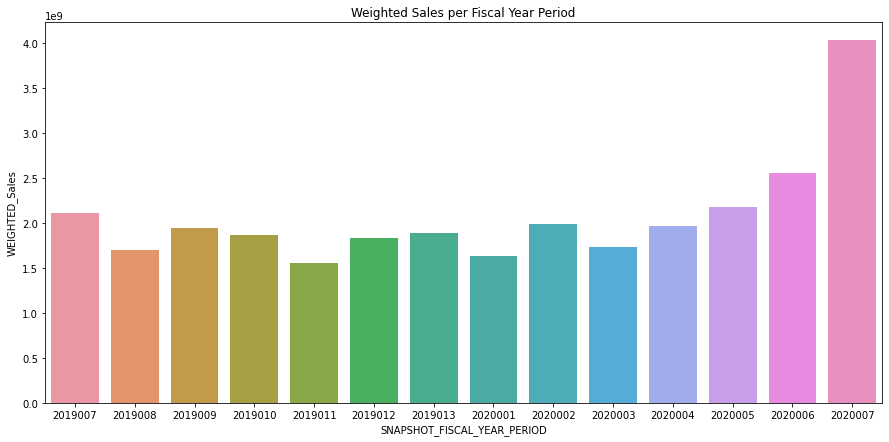

In [110]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(15)
plt.title('Weighted Sales per Fiscal Year Period')
sns.barplot(x='SNAPSHOT_FISCAL_YEAR_PERIOD', y='WEIGHTED_Sales', data=customer_model_df, \
            order=fiscal_yp_list, estimator=np.sum, ci=None)
plt.show()

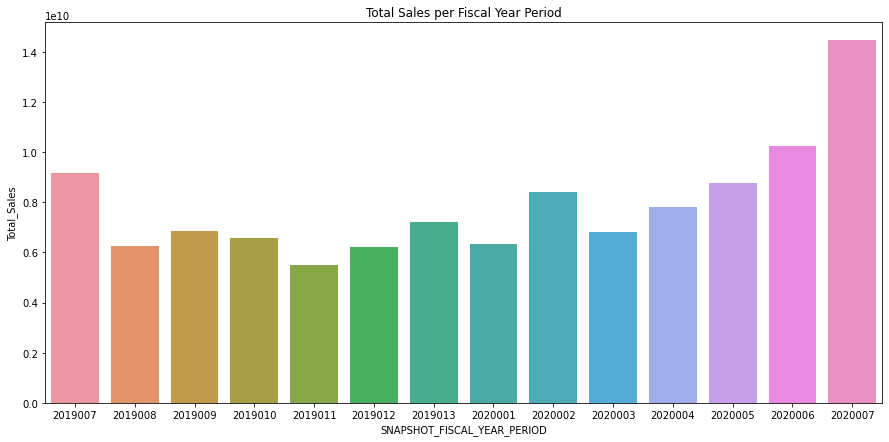

In [111]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(15)
plt.title('Total Sales per Fiscal Year Period')
sns.barplot(x='SNAPSHOT_FISCAL_YEAR_PERIOD', y='Total_Sales', data=customer_model_df, \
            order=fiscal_yp_list, estimator=np.sum, ci=None)
plt.show()

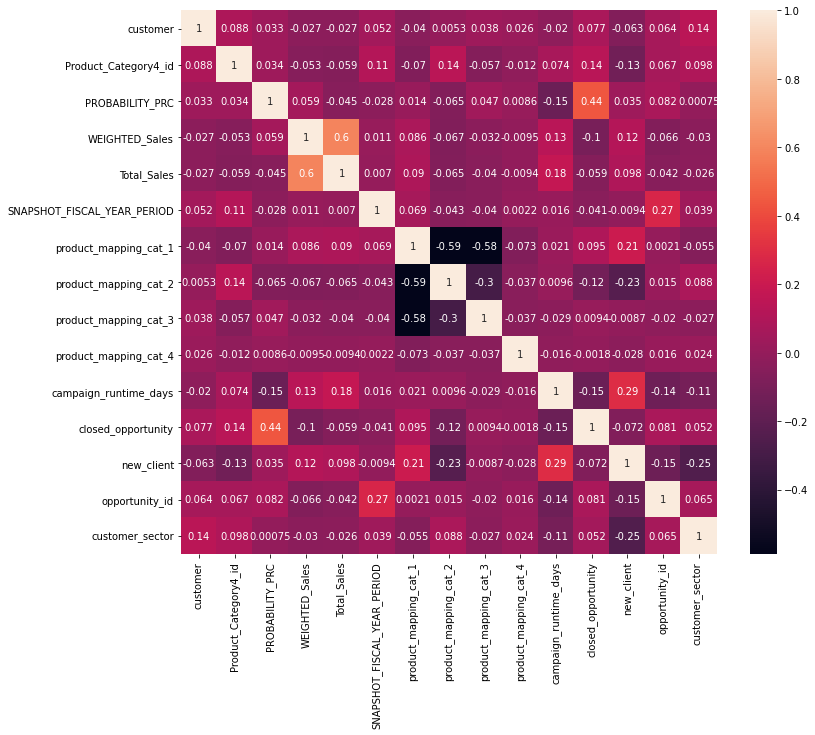

In [112]:
plt.subplots(figsize=(12,10))
sns.heatmap(customer_model_df.corr(),annot=True)
plt.show()

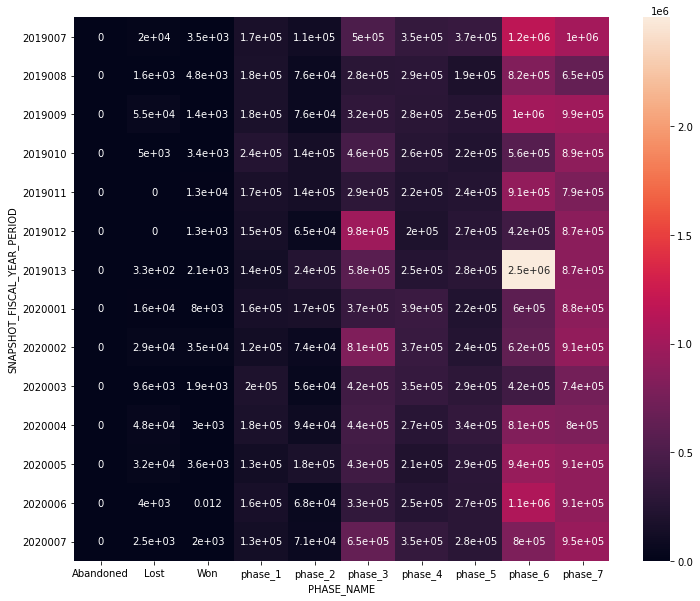

In [113]:
df_heatmap = customer_model_df.pivot_table(values='WEIGHTED_Sales', index='SNAPSHOT_FISCAL_YEAR_PERIOD',\
                                           columns=['PHASE_NAME'])
plt.subplots(figsize=(12,10))
sns.heatmap(df_heatmap,annot=True)
plt.show()

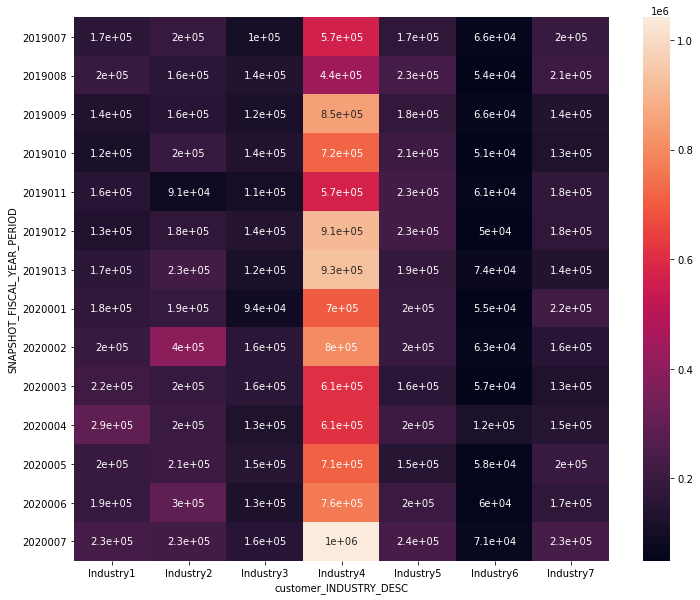

In [114]:
df_heatmap = customer_model_df.pivot_table(values='WEIGHTED_Sales', index='SNAPSHOT_FISCAL_YEAR_PERIOD',\
                                           columns=['customer_INDUSTRY_DESC'])
plt.subplots(figsize=(12,10))
sns.heatmap(df_heatmap,annot=True)
plt.show()

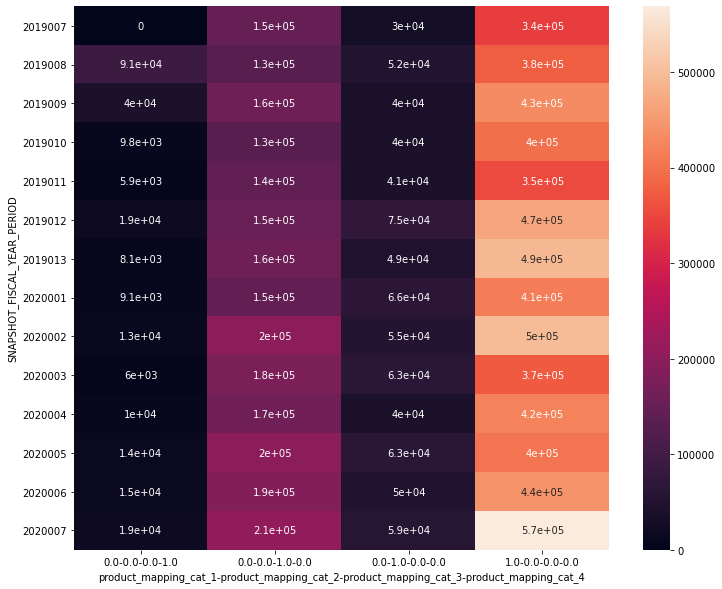

In [115]:
df_heatmap = customer_model_df.pivot_table(values='WEIGHTED_Sales', index='SNAPSHOT_FISCAL_YEAR_PERIOD',\
                                           columns=['product_mapping_cat_1', 'product_mapping_cat_2', \
                                                    'product_mapping_cat_3', 'product_mapping_cat_4'])
plt.subplots(figsize=(12,10))
sns.heatmap(df_heatmap,annot=True)
plt.show()

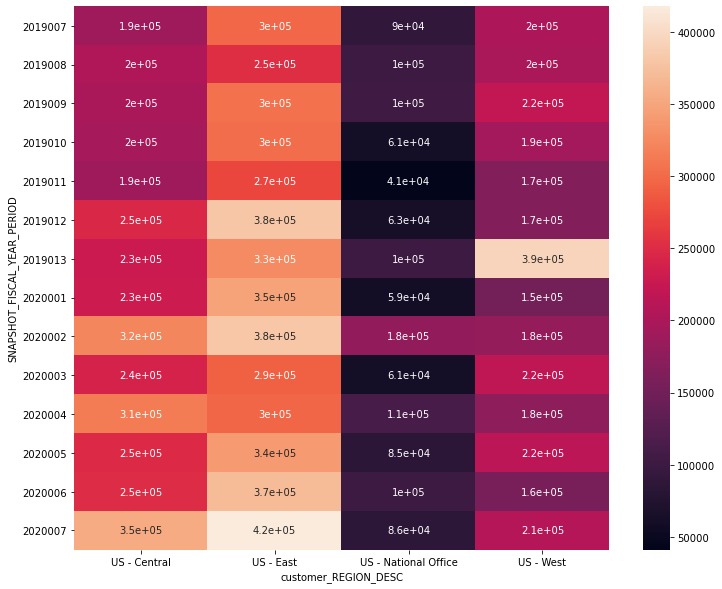

In [116]:
df_heatmap = customer_model_df.pivot_table(values='WEIGHTED_Sales', index='SNAPSHOT_FISCAL_YEAR_PERIOD',\
                                           columns=['customer_REGION_DESC'])
plt.subplots(figsize=(12,10))
sns.heatmap(df_heatmap,annot=True)
plt.show()

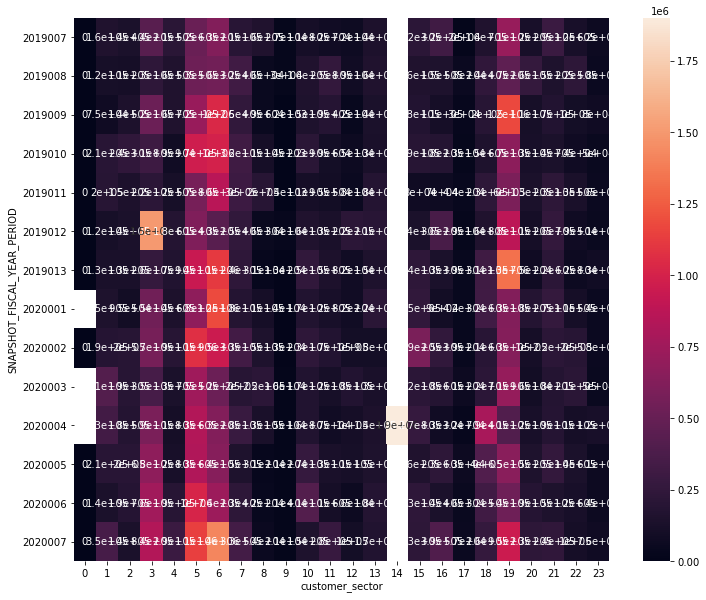

In [117]:
df_heatmap = customer_model_df.pivot_table(values='WEIGHTED_Sales', index='SNAPSHOT_FISCAL_YEAR_PERIOD',\
                                           columns=['customer_sector'])
plt.subplots(figsize=(12,10))
sns.heatmap(df_heatmap,annot=True)
plt.show()

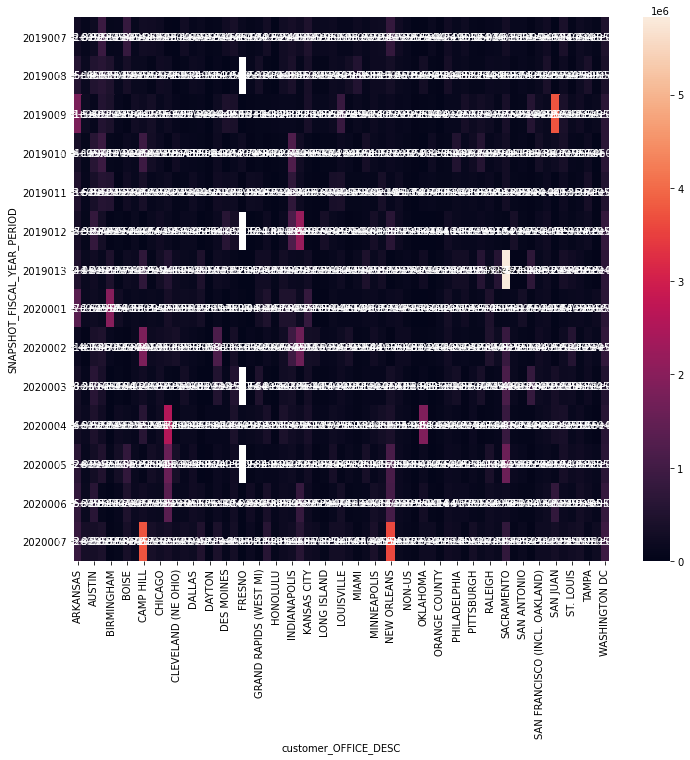

In [118]:
df_heatmap = customer_model_df.pivot_table(values='WEIGHTED_Sales', index='SNAPSHOT_FISCAL_YEAR_PERIOD',\
                                           columns=['customer_OFFICE_DESC'])
plt.subplots(figsize=(12,10))
sns.heatmap(df_heatmap,annot=True)
plt.show()

In [119]:
# def model_features(col_name, new_col):
#     customer_model_df2[new_col] = customer_model_df[col_name].apply(lambda x: 1 if x==new_col else 0)
#     customer_model_df2[new_col] = customer_model_df2[new_col].astype('int')

In [120]:
# customer_model_df2 = pd.DataFrame()
# customer_model_df2['weighted_sales'] = customer_model_df['WEIGHTED_Sales']
# customer_model_df2['Product_Category4_id'] = customer_model_df['Product_Category4_id']
# customer_model_df2['opportunity_id'] = customer_model_df['opportunity_id']
# customer_model_df2['SNAPSHOT_FISCAL_YEAR_PERIOD'] = customer_model_df['SNAPSHOT_FISCAL_YEAR_PERIOD']
# customer_model_df2['closed_opportunity'] = customer_model_df['closed_opportunity']
# customer_model_df2['new_client'] = customer_model_df['new_client']
# customer_model_df2['campaign_runtime_days'] = customer_model_df['campaign_runtime_days']
# model_features('PHASE_NAME', 'phase 7')
# model_features('customer_INDUSTRY_DESC', 'Industry4')
# model_features('customer_REGION_DESC', 'US - East')
# model_features('customer_REGION_DESC', 'US - Central')
# model_features('customer_sector', '19')
# model_features('customer_sector', '6')
# model_features('customer_sector', '5')
# model_features('customer_OFFICE_DESC', 'CAMP HILL')
# customer_model_df2['product_mapping_cat_4'] = customer_model_df['product_mapping_cat_4']

In [121]:
customer_model_df = customer_model_df[customer_model_df['WEIGHTED_Sales'].notnull()]

In [122]:
customer_model_df['campaign_runtime_days'].fillna(customer_model_df['campaign_runtime_days'].mean(), inplace=True)

In [123]:
customer_model_df['PHASE_NAME'] = customer_model_df['PHASE_NAME'].astype('category')

In [124]:
customer_model_df['won'] = customer_model_df['PHASE_NAME'].apply(lambda x:1 if x=='Won' else 0)

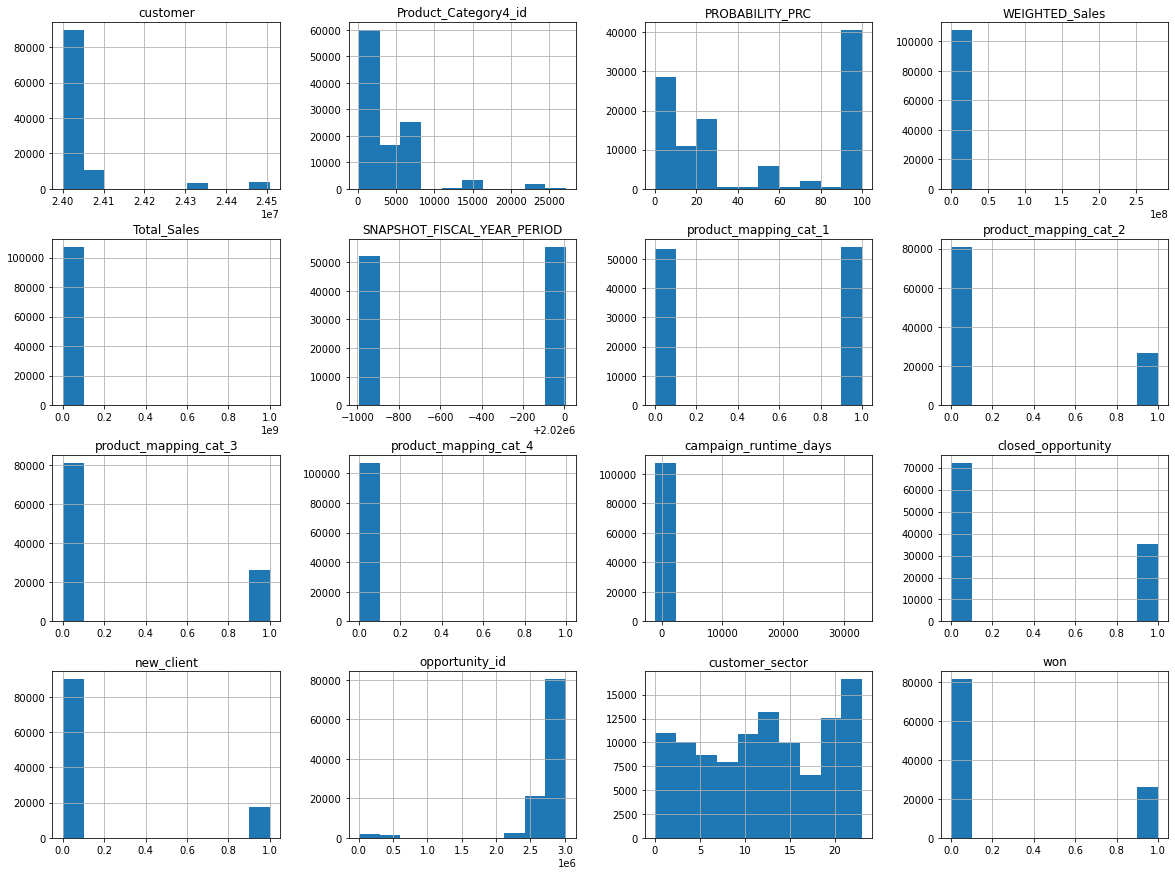

In [125]:
customer_model_df.hist(figsize=(20,15))
plt.show()

In [126]:
X = customer_model_df.drop(['won', 'PHASE_NAME', 'closed_opportunity', 'WEIGHTED_Sales', 'PROBABILITY_PRC'], axis=1)
y = customer_model_df.won

In [127]:
X.columns

Index(['customer', 'Product_Category4_id', 'Product_Category2_text',
       'Product_Category3_text', 'CURRENCY', 'Total_Sales',
       'SNAPSHOT_FISCAL_YEAR_PERIOD', 'customer_INDUSTRY_DESC',
       'customer_OFFICE_DESC', 'customer_REGION_DESC', 'product_mapping_cat_1',
       'product_mapping_cat_2', 'product_mapping_cat_3',
       'product_mapping_cat_4', 'campaign_runtime_days', 'new_client',
       'opportunity_id', 'customer_sector'],
      dtype='object')

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [129]:
# from sklearn.model_selection import GridSearchCV
# parameters = {"n_neighbors": range(1, 10)}
# model0 = make_pipeline(
#     OneHotEncoder(handle_unknown='ignore'),
#     SimpleImputer(strategy='most_frequent'),
#     GridSearchCV(KNeighborsClassifier(), parameters))

# model0.fit(X_train, y_train)

In [130]:
#model0.best_params_

In [131]:
model1 = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),
    SimpleImputer(strategy='most_frequent'),
    KNeighborsClassifier(n_neighbors=3))

model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)

In [132]:
error = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [133]:
print(error)
print(r2)

0.2039875018598423
-0.1214694239542855


In [134]:
rfor_model = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),
    SimpleImputer(strategy='most_frequent'),
    RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=2))

rfor_model.fit(X_train, y_train)
y_pred2 = rfor_model.predict(X_test)

In [135]:
error2 = mean_absolute_error(y_test, y_pred2)
r2_2 = r2_score(y_test, y_pred2)

In [136]:
print(error2)
print(r2_2)

0.18144621336110697
0.002456628364514213


Regression for WEIGHTED_Sales predictions

In [137]:
X = customer_model_df.drop(['WEIGHTED_Sales', 'customer_OFFICE_DESC', 'Product_Category2_text', 'Product_Category3_text'], axis=1)
y = customer_model_df.WEIGHTED_Sales
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [138]:
reg_rfor = make_pipeline(
    OneHotEncoder(handle_unknown='ignore'),
    SimpleImputer(strategy='most_frequent'),
    RandomForestRegressor(n_estimators=75, random_state=0, n_jobs=4))

reg_rfor.fit(X_train, y_train)
y_pred3 = reg_rfor.predict(X_test)

In [139]:
error3 = mean_absolute_error(y_test, y_pred3)
r2_3 = r2_score(y_test, y_pred3)
print(error3)
print(r2_3)

125894.05840077203
0.47256558053843667


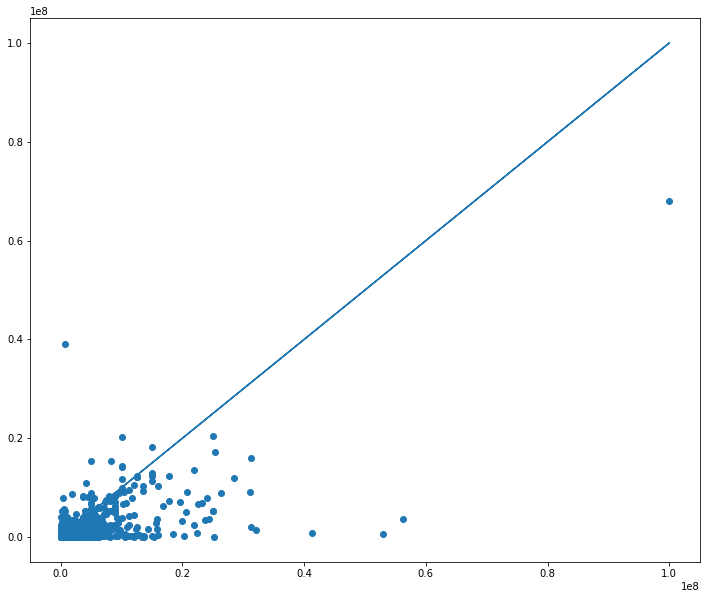

In [140]:
plt.subplots(figsize=(12,10))
plt.scatter(x=y_test, y=y_pred3)
plt.plot(y_test, y_test)

In [181]:
pred_df = pd.DataFrame(X_test)
pred_df['WEIGHTED_Sales'] = y_pred3

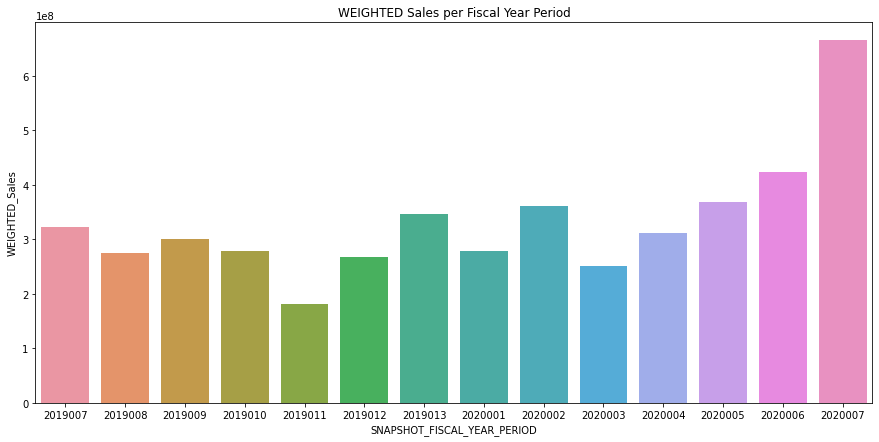

In [182]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(15)
plt.title('WEIGHTED Sales per Fiscal Year Period')
sns.barplot(x='SNAPSHOT_FISCAL_YEAR_PERIOD', y='WEIGHTED_Sales', data=pred_df, \
            order=fiscal_yp_list, estimator=np.sum, ci=None)
plt.show()

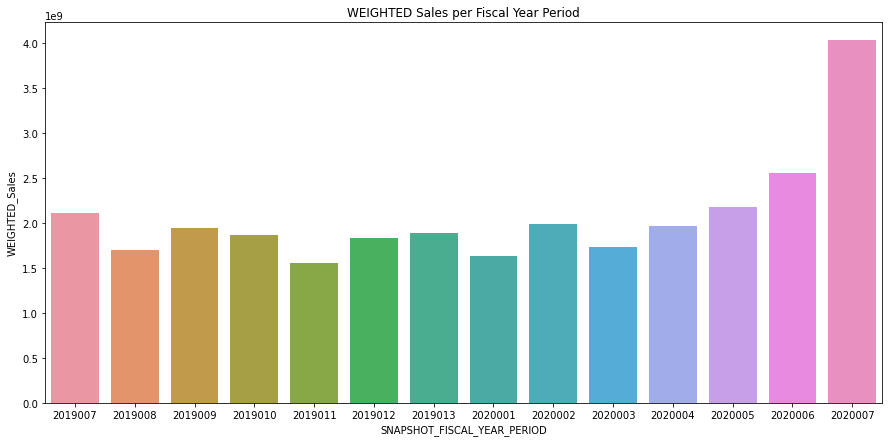

In [143]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(15)
plt.title('WEIGHTED Sales per Fiscal Year Period')
sns.barplot(x='SNAPSHOT_FISCAL_YEAR_PERIOD', y='WEIGHTED_Sales', data=customer_model_df, \
            order=fiscal_yp_list, estimator=np.sum, ci=None)
plt.show()

### 4.3 Where has the client seen the most success?

In [144]:
#Total_Sales separated by New_Client_Flag
customer_query_df1.groupby('New_Client_Flag', dropna=False)['Total_Sales'].sum()

New_Client_Flag
Y      2002709584
NaN    8129969316
Name: Total_Sales, dtype: int64

In [145]:
customer_query_df1.groupby('New_Client_Flag', dropna=False)['Total_Sales'].mean()

New_Client_Flag
Y      579152.569115
NaN    296335.677638
Name: Total_Sales, dtype: float64

**New customers on have higher average Total_Sales** in successful, closed opportunities than older customers.

**Overall, older customers have a higher summed Total_Sales** in successful, closed opportunities than newer customers.

In [146]:
#Total_Sales separated by region
customer_query_df1.groupby('customer_REGION_DESC', dropna=False)['Total_Sales'].sum().sort_values(ascending=False)

customer_REGION_DESC
US - East               4862005452
US - Central            3077490941
US - West               1638691977
US - National Office     550033225
NaN                        4457305
Name: Total_Sales, dtype: int64

In [147]:
#Total_Sales separated by Sector
customer_query_df1.groupby('customer_SECTOR_DESC', dropna=False)['Total_Sales'].sum().sort_values(ascending=False)

customer_SECTOR_DESC
Sector13    904624265
Sector7     816283886
Sector2     761750590
Sector20    715717738
Sector19    677310418
Sector21    665004811
Sector15    641069257
Sector5     593163567
Sector10    539179887
Sector4     524154801
Sector3     484214680
Sector11    482216535
Sector22    470063322
Sector18    460758745
Sector6     295789359
Sector12    270897491
Sector23    269520505
Sector1     232006262
Sector16    184007819
Sector17    108882433
Sector8      22701354
Sector9       9041570
NaN           4319605
Name: Total_Sales, dtype: int64

In [148]:
#Total_Sales separated by Office Desc
customer_query_df1.groupby('customer_OFFICE_DESC', dropna=False)['Total_Sales'].sum().sort_values(ascending=False)

customer_OFFICE_DESC
WASHINGTON DC                    1724517441
NEW YORK                         1148610891
CHICAGO                           562280371
SAN JOSE                          478875152
SAN FRANCISCO (INCL. OAKLAND)     455731330
                                    ...    
BIRMINGHAM                          7380236
NaN                                 4457305
DAYTON                              2108886
HONOLULU                            2079840
FRESNO                               325000
Name: Total_Sales, Length: 66, dtype: int64

In [149]:
#Total_Sales separated by Industry
customer_query_df1.groupby('customer_INDUSTRY_DESC', dropna=False)['Total_Sales'].sum().sort_values(ascending=False)

customer_INDUSTRY_DESC
Industry4    2050478024
Industry5    1720908151
Industry1    1686983130
Industry3    1623747049
Industry7    1380722549
Industry2    1364256963
Industry6     301263429
NaN             4319605
Name: Total_Sales, dtype: int64

In [150]:
#Total_Sales separated by Sale Lead
customer_query_df1.groupby('customer_salelead', dropna=False)['Total_Sales'].sum().sort_values(ascending=False)

customer_salelead
NaN             2248229226
sale lead652     199235814
sale lead983     115748632
sale lead635     111211904
sale lead468      99705848
                   ...    
sale lead139           745
sale lead258           495
sale lead494           295
sale lead525           295
sale lead439             1
Name: Total_Sales, Length: 970, dtype: int64

In [151]:
#Total_Sales separated by Sub Sector
customer_query_df1.groupby('customer_SUB_SECTOR_DESC', dropna=False)['Total_Sales'].sum().sort_values(ascending=False)

customer_SUB_SECTOR_DESC
Sub Sector7     761750590
Sub Sector8     613205989
Sub Sector56    564015952
Sub Sector15    480901531
Sub Sector21    417176501
                  ...    
Sub Sector32      3293649
Sub Sector11      3089789
Sub Sector5       2327431
Sub Sector51      1747000
Sub Sector59        19500
Name: Total_Sales, Length: 63, dtype: int64

### 5. Junk 

Assuming that the metric for success is through sheer amount of total sales, we can explore the following.

<AxesSubplot:ylabel='customer_REGION_DESC'>

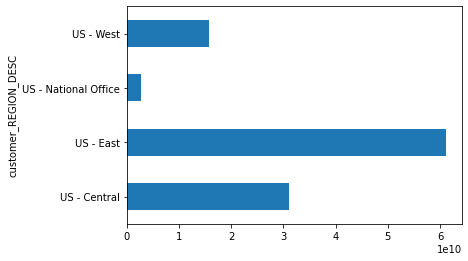

In [152]:
customer_df.groupby('customer_REGION_DESC')['Total_Sales'].sum().plot(kind='barh')

<AxesSubplot:title={'center':'Total Sales per Region'}, xlabel='Total_Sales', ylabel='customer_REGION_DESC'>

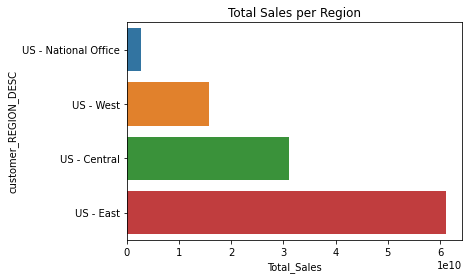

In [153]:
plt.title('Total Sales per Region')
sns.barplot(x='Total_Sales', y='customer_REGION_DESC', data=customer_df, estimator=np.sum, \
            ci=None, order=['US - National Office', 'US - West', 'US - Central', 'US - East'])

### The most total sales in US - East, least in US - National Office

In [154]:
customer_df.groupby('customer')['Total_Sales'].sum().sort_values(ascending=False).head()

customer
24024003.0    3651897582
24043533.0    2525252614
24048879.0    2173910762
24000882.0    1728767763
24036867.0    1686271106
Name: Total_Sales, dtype: int64

### Customers with most unweighted sales are 24024003, 24048879, 24000882, 24043533, 24028941.

In [155]:
customer_df[customer_df['customer']==24024003.0].groupby('PRIORITY')['WEIGHTED_Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
PRIORITY,,,,,,,,
High,14.0,1.460714e+06,2.163591e+06,0.0,0.000,112500.005,2500000.000,6250000.0
Low,4.0,3.812512e+04,6.147906e+04,0.5,8437.625,11250.000,40937.500,130000.0
Medium,8.0,1.974243e+05,2.724936e+05,0.0,0.000,0.000,521628.975,533066.4
Restricted: GPS Sector Priority,8.0,2.032500e+06,5.249114e+06,0.0,0.000,0.000,504000.000,15000000.0


In [156]:
customer_df[customer_df['customer']==24024003.0].groupby('product_mapping_cat_2')['WEIGHTED_Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
product_mapping_cat_2,,,,,,,,
0.0,364.0,950505.943819,2.580458e+06,0.0,0.0,20463.1,502525.05,25000000.0


In [157]:
customer_df[customer_df['customer']==24024003.0].groupby('product_mapping_cat_3')['WEIGHTED_Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
product_mapping_cat_3,,,,,,,,
0.0,289.0,1.038674e+06,2.769383e+06,0.0,0.0,50000.0,526234.5,25000000.0
1.0,75.0,6.107658e+05,1.633338e+06,0.0,0.0,0.0,236250.0,6801656.4


In [158]:
customer_df[customer_df['customer']==24024003.0].groupby('product_mapping_cat_4')['WEIGHTED_Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
product_mapping_cat_4,,,,,,,,
0.0,364.0,950505.943819,2.580458e+06,0.0,0.0,20463.1,502525.05,25000000.0


In [159]:
customer_df['Product_Category2_text'].value_counts()

category50    21181
category68    12778
category51     9094
category18     8536
category8      7630
category21     7521
category6      6776
category55     6067
category53     5980
category56     3838
category52     3722
category20     2342
category14     2066
category57     1769
category38     1677
category22     1507
category60     1432
category66     1366
category17     1360
category19     1317
category40      918
category2       765
category61      614
category12      568
category3       491
category7       454
category37      444
category67      437
category35      402
category65      384
category23      283
category58      272
category4       239
category64      146
category27      133
category33       90
category25       50
category9        48
category36       33
category46       22
category34        2
category15        2
category26        2
category41        2
category5         1
category42        1
category10        1
Name: Product_Category2_text, dtype: int64

In [160]:
customer_df.groupby('Product_Category2_text')['Total_Sales'].sum().sort_values(ascending=False)

Product_Category2_text
category18    22593096502
category8     20308531902
category21    12675085801
category51    11319607332
category52     9863044783
category68     9274652369
category53     4349275634
category50     4184420566
category6      3352520549
category56     1989224231
category38     1773021622
category14     1621269640
category57      947796443
category55      778835247
category22      719650189
category66      403766870
category17      403473054
category19      386198028
category65      346943123
category20      331702930
category40      290841986
category23      261288875
category35      259722860
category37      259335097
category7       244314554
category58      224073931
category60      217772379
category67      207663945
category12      151145803
category25      150901931
category61      138293411
category4       126464060
category3       113247995
category27       91183897
category64       85929072
category2        82133632
category9        29854797
category33     

In [161]:
customer_df.groupby('Product_Category2_text')['WEIGHTED_Sales'].sum().sort_values(ascending=False)

Product_Category2_text
category18    6.157352e+09
category8     4.125766e+09
category21    3.557795e+09
category52    3.307325e+09
category51    2.884307e+09
category68    2.336132e+09
category53    1.422506e+09
category50    1.051155e+09
category14    7.848110e+08
category56    6.435666e+08
category38    4.079109e+08
category57    3.156983e+08
category6     2.880433e+08
category22    1.931224e+08
category55    1.336065e+08
category19    1.259739e+08
category7     1.231164e+08
category20    1.076329e+08
category40    9.545650e+07
category37    8.693971e+07
category65    8.523359e+07
category25    7.679989e+07
category12    7.365877e+07
category17    7.198083e+07
category23    7.117029e+07
category60    6.919234e+07
category3     6.380529e+07
category67    6.261890e+07
category35    5.732848e+07
category66    4.066675e+07
category64    3.721698e+07
category58    2.817269e+07
category4     2.712843e+07
category27    2.629642e+07
category61    2.164444e+07
category9     1.373734e+07
categ

In [162]:
customer_df.groupby('Product_Category3_text')['Total_Sales'].sum().sort_values(ascending=False)

Product_Category3_text
sub category135    12535098271
sub category159    10689193360
sub category8       5737334379
sub category152     5509688643
sub category118     5357734265
                      ...     
sub category111         126001
sub category123         100000
sub category155          12750
sub category10               2
sub category78               1
Name: Total_Sales, Length: 131, dtype: int64

In [163]:
customer_df.groupby('Product_Category3_text')['WEIGHTED_Sales'].sum().sort_values(ascending=False)

Product_Category3_text
sub category159    3.177135e+09
sub category135    2.791804e+09
sub category8      1.691800e+09
sub category88     1.504855e+09
sub category118    1.460158e+09
                       ...     
sub category123    1.000000e+04
sub category10     4.000000e-01
sub category78     2.000000e-01
sub category160    0.000000e+00
sub category155    0.000000e+00
Name: WEIGHTED_Sales, Length: 131, dtype: float64

In [164]:
customer_df.groupby('PRIORITY')['WEIGHTED_Sales'].sum().sort_values(ascending=False)

PRIORITY
High                               2.401037e+09
Restricted: GPS Sector Priority    7.249940e+08
Medium                             7.074800e+08
Low                                6.692988e+07
Restricted: GPS Top Priority       1.558250e+07
Name: WEIGHTED_Sales, dtype: float64

In [165]:
customer_df.groupby('PRIORITY')['Total_Sales'].sum().sort_values(ascending=False)

PRIORITY
High                               6017316291
Restricted: GPS Sector Priority    2624926477
Medium                             2282442927
Low                                 234492631
Restricted: GPS Top Priority         29330011
Name: Total_Sales, dtype: int64

In [166]:
customer_df[customer_df['customer']==24039156.0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327 entries, 2028 to 517945
Data columns (total 41 columns):
 #   Column                             Non-Null Count  Dtype          
---  ------                             --------------  -----          
 0   OPPORTUNITY_OPEN_CLOSED_INDICATOR  327 non-null    object         
 1   PHASE_NAME                         327 non-null    object         
 2   PURSUIT_START_DATE                 327 non-null    datetime64[ns] 
 3   PROJECT_START_DATE                 307 non-null    datetime64[ns] 
 4   PROJECT_END_DATE                   307 non-null    datetime64[ns] 
 5   PERIOD_WON_LOSS_ABANDONED          73 non-null     object         
 6   DATE_WON_LOSS_ABANDONED            73 non-null     datetime64[ns] 
 7   PRIORITY                           25 non-null     object         
 8   customer                           327 non-null    float64        
 9   Product_Category4_id               327 non-null    float64        
 10  Product_Category2_te

In [167]:
customer_model_df

,PHASE_NAME,customer,Product_Category4_id,Product_Category2_text,Product_Category3_text,CURRENCY,PROBABILITY_PRC,WEIGHTED_Sales,Total_Sales,SNAPSHOT_FISCAL_YEAR_PERIOD,customer_INDUSTRY_DESC,customer_OFFICE_DESC,customer_REGION_DESC,product_mapping_cat_1,product_mapping_cat_2,product_mapping_cat_3,product_mapping_cat_4,campaign_runtime_days,closed_opportunity,new_client,opportunity_id,customer_sector,won
10,phase_5,24031560.0,1878.0,category68,sub category91,USD,25,137500.0,550000,2020002,Industry1,ST. LOUIS,US - Central,1.0,0.0,0.0,0.0,184.000000,0,0,28949,1,0
14,phase_4,24038172.0,3687.0,category40,sub category166,USD,75,900000.0,1200000,2019009,Industry7,SAN JOSE,US - West,0.0,0.0,1.0,0.0,249.268371,0,0,29759,20,0
29,phase_5,24039279.0,3756.0,category56,sub category16,USD,25,65000.0,260000,2019008,Industry3,SAN JOSE,US - West,0.0,0.0,1.0,0.0,108.000000,0,0,31941,2,0
30,phase_5,24039279.0,1995.0,category51,sub category152,USD,25,65000.0,260000,2019008,Industry3,SAN JOSE,US - West,1.0,0.0,0.0,0.0,108.000000,0,0,31941,2,0
47,phase_3,24001497.0,1629.0,category18,sub category116,USD,10,50000.0,500000,2019008,Industry2,SAN FRANCISCO (INCL. OAKLAND),US - West,1.0,0.0,0.0,0.0,122.000000,0,0,221459,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519065,phase_7,24043992.0,1689.0,category21,sub category48,USD,90,676485.9,751651,2019007,Industry4,WASHINGTON DC,US - East,1.0,0.0,0.0,0.0,364.000000,0,1,372037,6,0
519066,Abandoned,24002406.0,2004.0,category51,sub category8,USD,0,0.0,6000000,2019007,Industry3,DAVENPORT,US - Central,1.0,0.0,0.0,0.0,368.000000,1,0,373595,11,0
519067,Abandoned,24002406.0,2013.0,category51,sub category8,USD,0,0.0,3000000,2019007,Industry3,DAVENPORT,US - Central,1.0,0.0,0.0,0.0,368.000000,1,0,373595,11,0
519073,phase_3,24021531.0,3786.0,category56,sub category66,USD,10,15000.0,150000,2019007,Industry3,COLUMBUS,US - Central,0.0,0.0,1.0,0.0,249.268371,0,0,378615,2,0


In [168]:
customer_df['PHASE_NAME'].value_counts()

Won          30905
phase_1      21630
phase_7      13633
phase_3      11342
phase_4       9504
phase_5       9100
Abandoned     6600
Lost          5211
phase_2       4284
phase_6       2576
Name: PHASE_NAME, dtype: int64

In [169]:
customer_df[customer_df['PHASE_NAME']=='Lost']['PROBABILITY_PRC'].value_counts()

0      5176
50       31
20        1
100       1
25        1
10        1
Name: PROBABILITY_PRC, dtype: int64

In [170]:
cleaned_customer_opportunity['DATE_WON_LOSS_ABANDONED'].sort_values().value_counts()

7/24/2019     7475
3/8/2019       613
3/7/2019       398
7/16/2019      378
10/4/2019      377
              ... 
4/20/2019        6
11/30/2019       6
6/9/2019         4
12/26/2018       3
12/25/2018       3
Name: DATE_WON_LOSS_ABANDONED, Length: 392, dtype: int64

In [171]:
customer_df.to_csv('../Harris County/customer_df.csv')

In [172]:
customer_model_df.head()

,PHASE_NAME,customer,Product_Category4_id,Product_Category2_text,Product_Category3_text,CURRENCY,PROBABILITY_PRC,WEIGHTED_Sales,Total_Sales,SNAPSHOT_FISCAL_YEAR_PERIOD,customer_INDUSTRY_DESC,customer_OFFICE_DESC,customer_REGION_DESC,product_mapping_cat_1,product_mapping_cat_2,product_mapping_cat_3,product_mapping_cat_4,campaign_runtime_days,closed_opportunity,new_client,opportunity_id,customer_sector,won
10,phase_5,24031560.0,1878.0,category68,sub category91,USD,25,137500.0,550000,2020002,Industry1,ST. LOUIS,US - Central,1.0,0.0,0.0,0.0,184.000000,0,0,28949,1,0
14,phase_4,24038172.0,3687.0,category40,sub category166,USD,75,900000.0,1200000,2019009,Industry7,SAN JOSE,US - West,0.0,0.0,1.0,0.0,249.268371,0,0,29759,20,0
29,phase_5,24039279.0,3756.0,category56,sub category16,USD,25,65000.0,260000,2019008,Industry3,SAN JOSE,US - West,0.0,0.0,1.0,0.0,108.000000,0,0,31941,2,0
30,phase_5,24039279.0,1995.0,category51,sub category152,USD,25,65000.0,260000,2019008,Industry3,SAN JOSE,US - West,1.0,0.0,0.0,0.0,108.000000,0,0,31941,2,0
47,phase_3,24001497.0,1629.0,category18,sub category116,USD,10,50000.0,500000,2019008,Industry2,SAN FRANCISCO (INCL. OAKLAND),US - West,1.0,0.0,0.0,0.0,122.000000,0,0,221459,15,0


In [173]:
customer_query_df3 = customer_model_df.query("closed_opportunity == 1 & PHASE_NAME == 'Won'")
customer_query_df4 = customer_model_df.query("closed_opportunity == 1 & PHASE_NAME =='Lost'")
customer_query_df5 = customer_model_df.query("closed_opportunity == 0")

In [174]:
print(customer_query_df3['Total_Sales'].sum())
print(customer_query_df3['Total_Sales'].size)

10060167028
25947


In [175]:
print(customer_query_df4['Total_Sales'].sum())
print(customer_query_df4['Total_Sales'].size)

2531162528
2892


In [176]:
print(customer_query_df5['Total_Sales'].sum())
print(customer_query_df5['Total_Sales'].size)

90310121319
72111


In [177]:
print(customer_model_df['Total_Sales'].sum())
print(customer_model_df['Total_Sales'].size)

110465430331
107536


In [178]:
customer_query_df6 = customer_df['customer_INDUSTRY_DESC'].value_counts()
customer_query_df6

Industry1    21002
Industry3    19858
Industry4    19106
Industry2    17079
Industry5    17023
Industry7    15331
Industry6     5357
Name: customer_INDUSTRY_DESC, dtype: int64

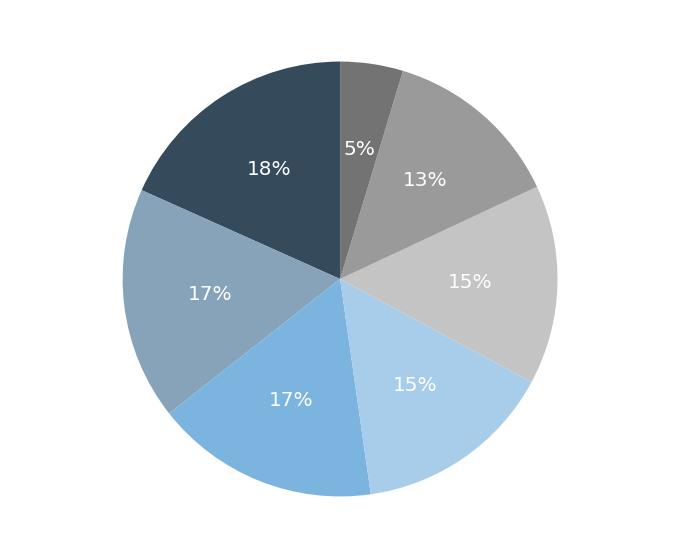

In [179]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
colors = ['#354b5c', '#86a3ba', '#7bb4df', '#a8cdea', '#c4c4c4', '#9a9a9a', '#737373']
plt.pie(x=customer_query_df6.values, labels=customer_query_df6.index, colors=colors, startangle = 90, autopct='%.0f%%', textprops={'fontsize': 20, 'color':'white'})
# handles, labels = plt.gca().get_legend_handles_labels()
# order = [1,3,2,0,4,6,5]
# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc=3)
plt.show()

In [180]:
#customer_model_df

In [183]:
fiscal_yp_list = customer_df['SNAPSHOT_FISCAL_YEAR_PERIOD'].values
fiscal_yp_list = set(fiscal_yp_list.tolist())
fiscal_yp_list = list(fiscal_yp_list)
fiscal_yp_list.sort()
fiscal_yp_list

[2019007,
 2019008,
 2019009,
 2019010,
 2019011,
 2019012,
 2019013,
 2020001,
 2020002,
 2020003,
 2020004,
 2020005,
 2020006,
 2020007]

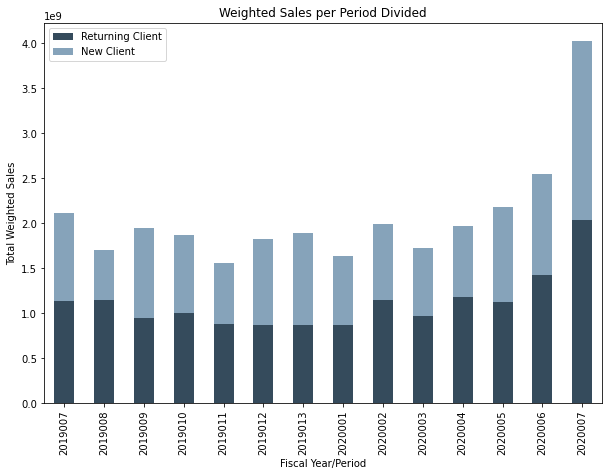

In [225]:
ax = customer_model_df.groupby(['SNAPSHOT_FISCAL_YEAR_PERIOD', 'new_client'])['WEIGHTED_Sales']\
                            .sum().unstack().plot(kind='bar', stacked=True, figsize=(10,7),\
                                                 color=colors)
plt.title('Weighted Sales per Period Divided')
plt.legend(['Returning Client', 'New Client'])
plt.xlabel('Fiscal Year/Period')
plt.ylabel('Total Weighted Sales')
plt.show()

In [205]:
df_plot

,new_client,WEIGHTED_Sales
SNAPSHOT_FISCAL_YEAR_PERIOD,,
2019007,0,1.132153e+09
2019007,1,9.788760e+08
2019008,0,1.149190e+09
2019008,1,5.496509e+08
2019009,0,9.503919e+08
2019009,1,9.994095e+08
2019010,0,1.003390e+09
2019010,1,8.677347e+08
2019011,0,8.753744e+08


In [221]:
customer_model_df

,PHASE_NAME,customer,Product_Category4_id,Product_Category2_text,Product_Category3_text,CURRENCY,PROBABILITY_PRC,WEIGHTED_Sales,Total_Sales,SNAPSHOT_FISCAL_YEAR_PERIOD,customer_INDUSTRY_DESC,customer_OFFICE_DESC,customer_REGION_DESC,product_mapping_cat_1,product_mapping_cat_2,product_mapping_cat_3,product_mapping_cat_4,campaign_runtime_days,closed_opportunity,new_client,opportunity_id,customer_sector,won
10,phase_5,24031560.0,1878.0,category68,sub category91,USD,25,137500.0,550000,2020002,Industry1,ST. LOUIS,US - Central,1.0,0.0,0.0,0.0,184.000000,0,0,28949,1,0
14,phase_4,24038172.0,3687.0,category40,sub category166,USD,75,900000.0,1200000,2019009,Industry7,SAN JOSE,US - West,0.0,0.0,1.0,0.0,249.268371,0,0,29759,20,0
29,phase_5,24039279.0,3756.0,category56,sub category16,USD,25,65000.0,260000,2019008,Industry3,SAN JOSE,US - West,0.0,0.0,1.0,0.0,108.000000,0,0,31941,2,0
30,phase_5,24039279.0,1995.0,category51,sub category152,USD,25,65000.0,260000,2019008,Industry3,SAN JOSE,US - West,1.0,0.0,0.0,0.0,108.000000,0,0,31941,2,0
47,phase_3,24001497.0,1629.0,category18,sub category116,USD,10,50000.0,500000,2019008,Industry2,SAN FRANCISCO (INCL. OAKLAND),US - West,1.0,0.0,0.0,0.0,122.000000,0,0,221459,15,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519065,phase_7,24043992.0,1689.0,category21,sub category48,USD,90,676485.9,751651,2019007,Industry4,WASHINGTON DC,US - East,1.0,0.0,0.0,0.0,364.000000,0,1,372037,6,0
519066,Abandoned,24002406.0,2004.0,category51,sub category8,USD,0,0.0,6000000,2019007,Industry3,DAVENPORT,US - Central,1.0,0.0,0.0,0.0,368.000000,1,0,373595,11,0
519067,Abandoned,24002406.0,2013.0,category51,sub category8,USD,0,0.0,3000000,2019007,Industry3,DAVENPORT,US - Central,1.0,0.0,0.0,0.0,368.000000,1,0,373595,11,0
519073,phase_3,24021531.0,3786.0,category56,sub category66,USD,10,15000.0,150000,2019007,Industry3,COLUMBUS,US - Central,0.0,0.0,1.0,0.0,249.268371,0,0,378615,2,0


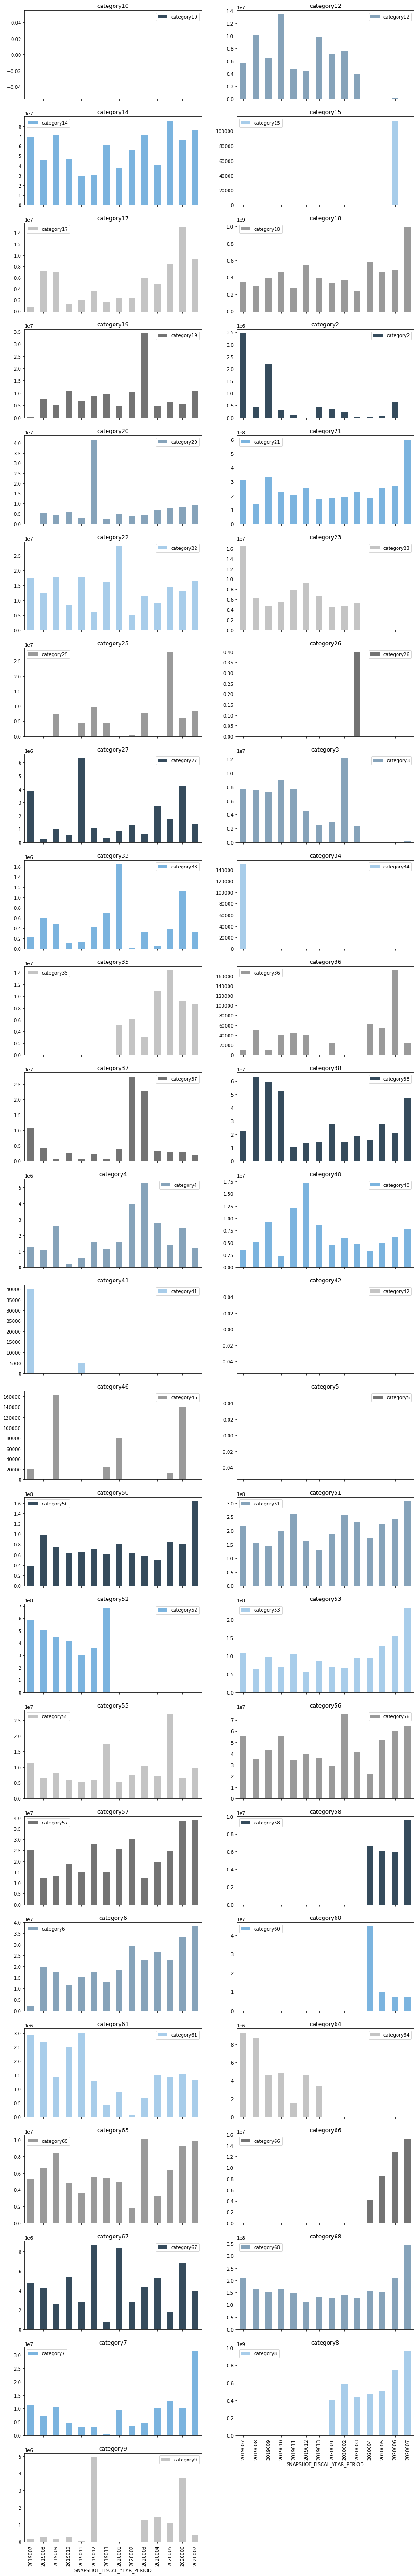

In [244]:
customer_model_df.groupby(['SNAPSHOT_FISCAL_YEAR_PERIOD', 'Product_Category2_text'])\
                        ['WEIGHTED_Sales'].sum().sort_values(ascending=False).unstack()\
                                          .plot(kind='bar', stacked=False, figsize=(15,100),\
                                          subplots=True, layout=(24,2), color=colors)
plt.title('Weighted Sales per Period Divided')
plt.xlabel('Fiscal Year/Period')
plt.ylabel('Total Weighted Sales')
plt.show()

In [265]:
customer_model_df['Product_Category2_text'].value_counts().index.size

47

In [271]:
customer_model_df.groupby('Product_Category4_id')['WEIGHTED_Sales'].sum().sort_values(ascending=True).head(38)

Product_Category4_id
6015.000000    0.000000
21294.000000   0.000000
726.000000     0.000000
732.000000     0.000000
5943.000000    0.000000
5958.000000    0.000000
1266.000000    0.000000
801.000000     0.000000
1245.000000    0.000000
1233.000000    0.000000
15813.000000   0.000000
888.000000     0.000000
6051.000000    0.000000
6069.000000    0.000000
15438.000000   0.000000
1113.000000    0.000000
1092.000000    0.000000
1080.000000    0.000000
927.000000     0.000000
972.000000     0.000000
4647.000000    0.000000
4641.000000    0.000000
1680.000000    0.000000
657.000000     0.000000
25032.000000   0.000000
3198.000000    0.000000
3330.000000    0.000000
3387.000000    0.000000
24963.000000   0.000000
24918.000000   0.000000
4632.000000    0.000000
24768.000000   0.000000
3522.000000    0.000000
1839.000000    0.000000
3399.000000    0.000000
942.000000     0.000000
4629.000000    0.000000
5241.000000    0.100000
Name: WEIGHTED_Sales, dtype: float64

In [272]:
customer_model_df.groupby('Product_Category2_text')['WEIGHTED_Sales'].sum().sort_values(ascending=False).head(5)

Product_Category2_text
category18   6157351527.940004
category8    4125766049.649995
category21   3557795425.389999
category52   3307325336.600000
category51   2884306571.909999
Name: WEIGHTED_Sales, dtype: float64

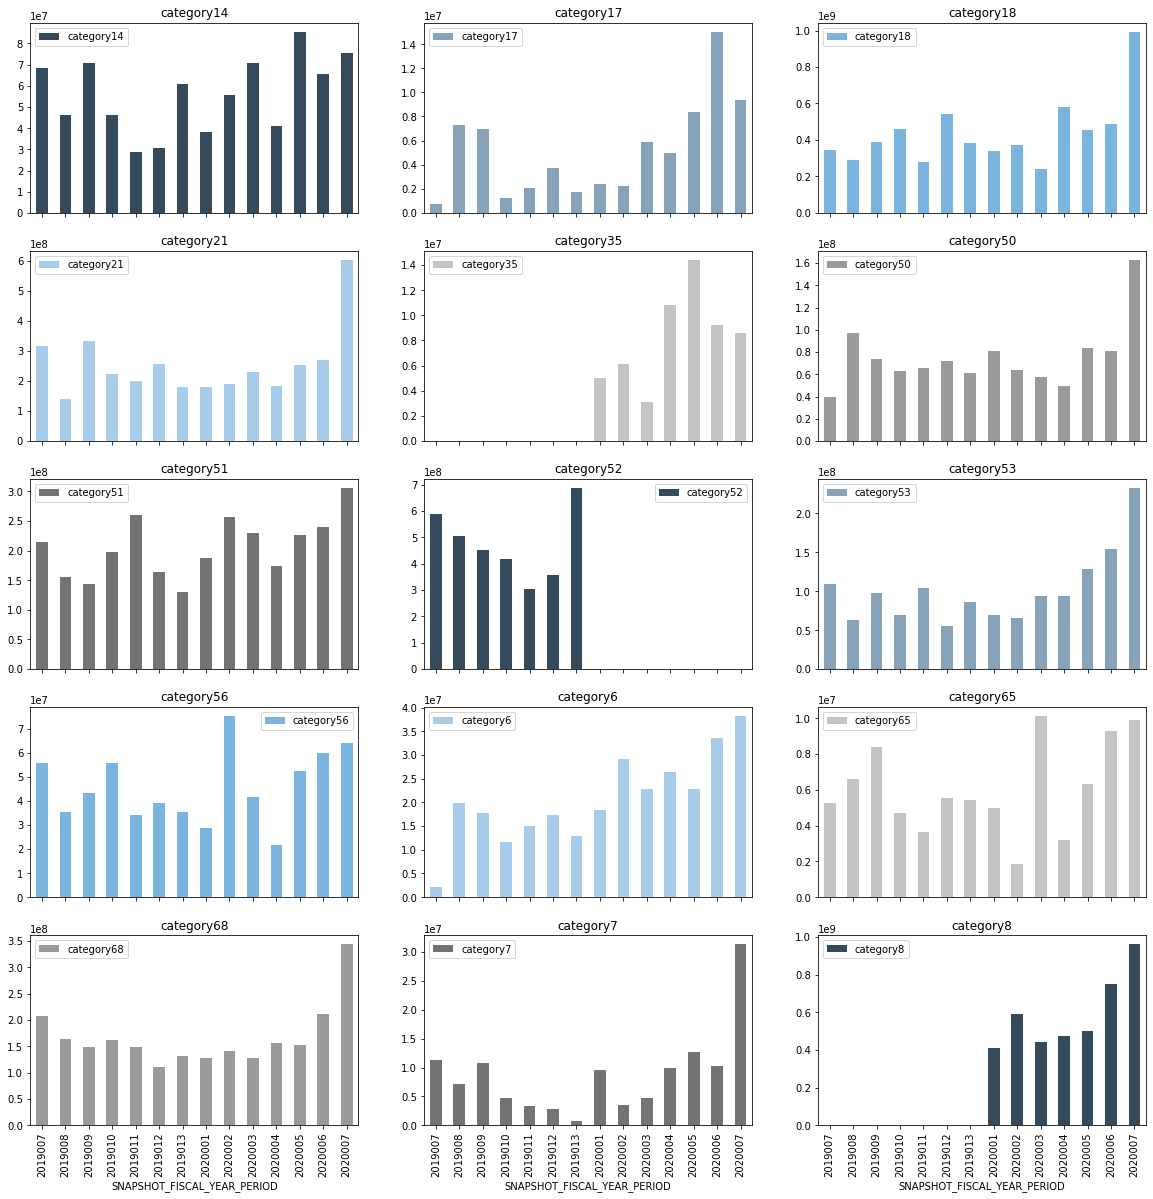

In [282]:
cat2list = ['category6', 'category7', 'category8', 'category14', 'category17', 'category18', 'category21', 'category35', 'category50', 'category51', 'category53', 'category56', 'category52', 'category65', 'category68']
temp_df = customer_model_df[customer_model_df['Product_Category2_text'].isin(cat2list)]
temp_df.groupby(['SNAPSHOT_FISCAL_YEAR_PERIOD', 'Product_Category2_text'])\
                        ['WEIGHTED_Sales'].sum().unstack()\
                                          .plot(kind='bar', stacked=False, figsize=(20,100),\
                                          subplots=True, layout=(24,3), color=colors)
plt.title('Weighted Sales per Period Divided')
plt.xlabel('Fiscal Year/Period')
plt.ylabel('Total Weighted Sales')
plt.show()

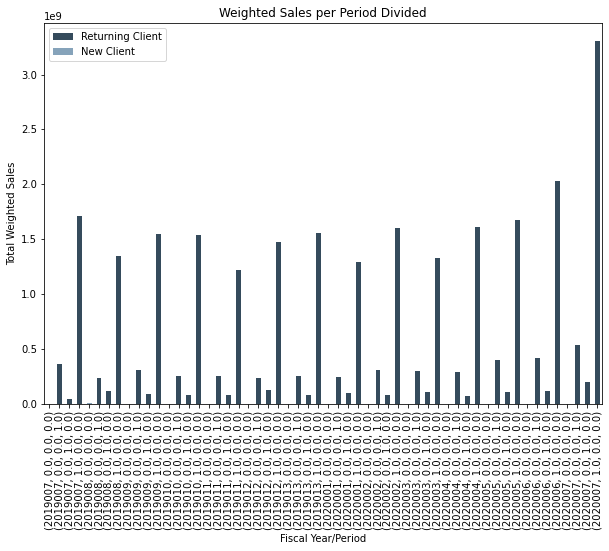

In [283]:
customer_model_df.groupby(['SNAPSHOT_FISCAL_YEAR_PERIOD', 'product_mapping_cat_1', 'product_mapping_cat_2','product_mapping_cat_3', 'product_mapping_cat_4'])['WEIGHTED_Sales']\
                            .sum().unstack().plot(kind='bar', stacked=True, figsize=(10,7),\
                                                 color=colors)
plt.title('Weighted Sales per Period Divided')
plt.xlabel('Fiscal Year/Period')
plt.ylabel('Total Weighted Sales')
plt.show()

In [301]:
temp_df = pd.DataFrame()
temp_df['SNAPSHOT_FISCAL_YEAR_PERIOD'] = customer_model_df['SNAPSHOT_FISCAL_YEAR_PERIOD']
temp_df['product_mapping_category'] = customer_model_df['product_mapping_cat_1'] +\
                                      2*customer_model_df['product_mapping_cat_2'] +\
                                      3*customer_model_df['product_mapping_cat_3'] +\
                                      4*customer_model_df['product_mapping_cat_4']
temp_df['product_mapping_cat_1'] = customer_model_df['product_mapping_cat_1']
temp_df['product_mapping_cat_2'] = customer_model_df['product_mapping_cat_2']
temp_df['product_mapping_cat_3'] = customer_model_df['product_mapping_cat_3']
temp_df['product_mapping_cat_4'] = customer_model_df['product_mapping_cat_4']
temp_df['WEIGHTED_Sales'] = customer_model_df['WEIGHTED_Sales']
temp_df

,SNAPSHOT_FISCAL_YEAR_PERIOD,product_mapping_category,product_mapping_cat_1,product_mapping_cat_2,product_mapping_cat_3,product_mapping_cat_4,WEIGHTED_Sales
10,2020002,1.000000,1.000000,0.000000,0.000000,0.000000,137500.000000
14,2019009,3.000000,0.000000,0.000000,1.000000,0.000000,900000.000000
29,2019008,3.000000,0.000000,0.000000,1.000000,0.000000,65000.000000
30,2019008,1.000000,1.000000,0.000000,0.000000,0.000000,65000.000000
47,2019008,1.000000,1.000000,0.000000,0.000000,0.000000,50000.000000
...,...,...,...,...,...,...,...
519065,2019007,1.000000,1.000000,0.000000,0.000000,0.000000,676485.900000
519066,2019007,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
519067,2019007,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
519073,2019007,3.000000,0.000000,0.000000,1.000000,0.000000,15000.000000


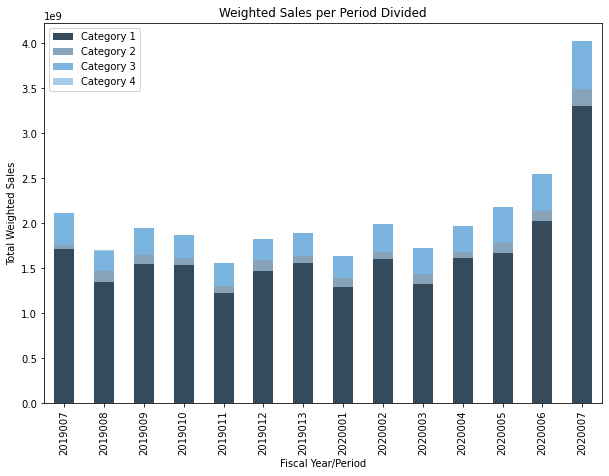

In [314]:
temp_df.groupby(['SNAPSHOT_FISCAL_YEAR_PERIOD', 'product_mapping_category'])['WEIGHTED_Sales']\
                            .sum().unstack().plot(kind='bar', stacked=True, figsize=(10,7),\
                                                 color=colors)
plt.title('Weighted Sales per Product Mapping Category')
plt.legend(['Category 1', 'Category 2', 'Category 3', 'Category 4'])
plt.xlabel('Fiscal Year/Period')
plt.ylabel('Total Weighted Sales')
plt.show()

In [323]:
temp_df.groupby('product_mapping_category')['WEIGHTED_Sales'].mean()

product_mapping_category
1.000000   429069.829886
2.000000    51683.861360
3.000000   166354.942491
4.000000    18125.626091
Name: WEIGHTED_Sales, dtype: float64

In [324]:
#pivot_table.plot(kind='bar', x='SNAPSHOT_FISCAL_YEAR_PERIOD', y='WEIGHTED_Sales', stacked=True, figsize=(10,7),color=colors)

In [325]:
customer_model_df.groupby('Product_Category3_text')['WEIGHTED_Sales'].sum().sort_values(ascending=False).head(5)

Product_Category3_text
sub category159   3177135375.599998
sub category135   2791803864.249999
sub category8     1691799922.659998
sub category88    1504854812.460000
sub category118   1460157706.150000
Name: WEIGHTED_Sales, dtype: float64

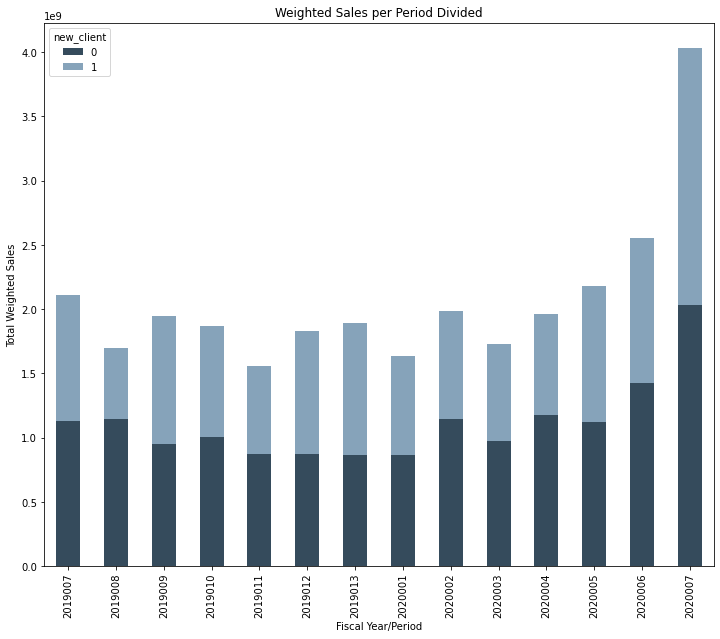

In [332]:
customer_model_df.groupby(['SNAPSHOT_FISCAL_YEAR_PERIOD', 'new_client'])\
                        ['WEIGHTED_Sales'].sum().sort_values(ascending=False).unstack()\
                                          .plot(kind='bar', stacked=True, figsize=(12,10),\
                                          color=colors)
plt.title('Weighted Sales per Period Divided')
plt.xlabel('Fiscal Year/Period')
plt.ylabel('Total Weighted Sales')
plt.show()

In [345]:
customer_model_df.groupby('customer')['WEIGHTED_Sales'].mean().sort_values(ascending=False).head(10)

customer
24344625.000000   9500000.000000
24011466.000000   9312500.000000
24059166.000000   7500000.000000
24050349.000000   7220625.000000
24470877.000000   6583388.400000
24039504.000000   5500000.000000
24028107.000000   5322916.666667
24502194.000000   5000000.250000
24017763.000000   5000000.000000
24026649.000000   5000000.000000
Name: WEIGHTED_Sales, dtype: float64

In [347]:
customer_model_df[customer_model_df['customer'].isin([24018057, 24048879, 24035370, 24000954,\
        24043533, 24041244, 24036867, 24028941, 24043992, 24000882])].groupby('customer')['WEIGHTED_Sales'].mean()

customer
24000882.000000   1860850.733255
24000954.000000   1980484.713043
24018057.000000   2272854.563344
24028941.000000    600127.005421
24035370.000000   2230329.368595
24036867.000000    861675.236640
24041244.000000   1034103.066784
24043533.000000   1562525.449483
24043992.000000   1419018.997059
24048879.000000    600152.125376
Name: WEIGHTED_Sales, dtype: float64

In [348]:
customer_model_df[customer_model_df['customer'].isin([24018057, 24048879, 24035370, 24000954,\
        24043533, 24041244, 24036867, 24028941, 24043992, 24000882])].groupby('customer')['opportunity_id'].count()

customer
24000882.000000    212
24000954.000000    230
24018057.000000    311
24028941.000000    701
24035370.000000    242
24036867.000000    509
24041244.000000    426
24043533.000000    290
24043992.000000    289
24048879.000000    997
Name: opportunity_id, dtype: int64

In [351]:
customer_model_df[customer_model_df['customer'].isin([24018057, 24048879, 24035370, 24000954,\
        24043533, 24041244, 24036867, 24028941, 24043992, 24000882])].groupby('customer')['won'].value_counts()

customer         won
24000882.000000  0      177
                 1       35
24000954.000000  0      195
                 1       35
24018057.000000  0      228
                 1       83
24028941.000000  0      625
                 1       76
24035370.000000  0      197
                 1       45
24036867.000000  0      412
                 1       97
24041244.000000  0      393
                 1       33
24043533.000000  0      232
                 1       58
24043992.000000  0      256
                 1       33
24048879.000000  0      773
                 1      224
Name: won, dtype: int64

In [369]:
customer_model_df['fiscal_year'] = customer_model_df['SNAPSHOT_FISCAL_YEAR_PERIOD'].apply(lambda x:int(str(x)[:4]))

In [371]:
customer_model_df.groupby(['fiscal_year', 'new_client'])['WEIGHTED_Sales'].sum()

fiscal_year  new_client
2019         0            6850818411.020020
             1            6056427215.320005
2020         0            8743468655.680006
             1            7340227356.120025
Name: WEIGHTED_Sales, dtype: float64

In [372]:
customer_model_df.groupby(['fiscal_year', 'customer_INDUSTRY_DESC'])['WEIGHTED_Sales'].sum()

fiscal_year  customer_INDUSTRY_DESC
2019         Industry1                1433774372.550000
             Industry2                1385092325.240000
             Industry3                1154204501.530000
             Industry4                6097531388.820003
             Industry5                1613699515.899998
             Industry6                 130603825.350000
             Industry7                1092339696.950000
2020         Industry1                2184317648.600000
             Industry2                2017925436.779999
             Industry3                1336945558.940000
             Industry4                7413050831.770023
             Industry5                1662796085.949999
             Industry6                 183868475.100000
             Industry7                1284791974.660001
Name: WEIGHTED_Sales, dtype: float64

In [373]:
customer_model_df.groupby(['fiscal_year', 'customer_REGION_DESC'])['WEIGHTED_Sales'].sum()

fiscal_year  customer_REGION_DESC
2019         US - Central           3274365969.459997
             US - East              7469171098.330010
             US - National Office    197127974.550000
             US - West              1966580583.999999
2020         US - Central           4772158877.980000
             US - East              9163566295.420033
             US - National Office    284744234.230000
             US - West              1863201604.169999
Name: WEIGHTED_Sales, dtype: float64

In [383]:
index = customer_model_df.groupby('Product_Category4_id')['WEIGHTED_Sales'].sum().sort_values(ascending=False).head().index
index

Float64Index([1650.0, 2061.0, 1818.0, 2004.0, 1629.0], dtype='float64', name='Product_Category4_id')

In [384]:
customer_model_df[customer_model_df['Product_Category4_id'].isin(index)].groupby(['fiscal_year', 'Product_Category4_id'])['WEIGHTED_Sales'].sum()

fiscal_year  Product_Category4_id
2019         1629.000000             357677003.200000
             1650.000000             526978559.220000
             1818.000000             375658065.750000
             2004.000000             403860361.450000
             2061.000000             591734150.260000
2020         1629.000000             448149619.260000
             1650.000000            1157333961.150000
             1818.000000             730103540.100000
             2004.000000             535241533.810000
             2061.000000             572925520.050000
Name: WEIGHTED_Sales, dtype: float64